In [3]:
import requests
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from nltk.sentiment import sentiment_analyzer, vader, SentimentAnalyzer, SentimentIntensityAnalyzer
from xgboost import XGBClassifier
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from transformers import pipeline

%config InlineBackend.figure_format = 'retina'

### Getting data from Ask Men Subreddit ###

In [ ]:
url_submissions = 'https://api.pushshift.io/reddit/search/submission'
url_comments = 'https://api.pushshift.io/reddit/search/comment'

In [ ]:
AM_posts_cols = ['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'removed_by_category', 'retrieved_on', 'score', 'selftext',
       'send_replies', 'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'subreddit_subscribers', 'subreddit_type', 'thumbnail', 'title',
       'total_awards_received', 'treatment_tags', 'upvote_ratio', 'url',
       'whitelist_status', 'wls', 'post_hint', 'preview',
       'author_flair_background_color', 'author_flair_text_color',
       'banned_by']

In [ ]:
AM_posts_df = pd.DataFrame()#columns = AM_posts_cols)
before_params = [1609187173] # first timestamp is equivalent to now 
for i in range(1, 21):
    resp = requests.get(url_submissions, params = {'subreddit': 'AskMen','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        AM_posts_df = pd.concat([AM_posts_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
        time.sleep(2)
    except:
        print(resp.status_code)

In [ ]:
AM_posts_df.shape

In [ ]:
AM_posts_df['title_selftext'] = AM_posts_df['title']+AM_posts_df['selftext']
AM_posts_df[['title_selftext', 'title', 'selftext']].head()

In [ ]:
AM_comments_cols = ['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'comment_type',
       'created_utc', 'gildings', 'id', 'is_submitter', 'link_id', 'locked',
       'no_follow', 'parent_id', 'permalink', 'retrieved_on', 'score',
       'send_replies', 'stickied', 'subreddit', 'subreddit_id',
       'top_awarded_type', 'total_awards_received', 'treatment_tags',
       'distinguished']

In [ ]:
AM_comments_df = pd.DataFrame(columns = AM_comments_cols)
before_params = [1609187173] # first timestamp is equivalent to now 
for i in range(1, 21):
    resp = requests.get(url_comments, params = {'subreddit': 'AskMen','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        AM_comments_df = pd.concat([AM_comments_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
        time.sleep(2)
    except:
        print(resp.status_code)

In [5]:
AM_comments_df.shape

(1800, 41)

### Getting data from AskWomen Subreddit ###

In [ ]:
resp = requests.get(url_submissions, params = {'subreddit': 'AskWomen','size': 100,'before': before_params[-1]})
pd.DataFrame(resp.json()['data']).columns

In [ ]:
AW_posts_cols = ['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'post_hint',
       'preview', 'pwls', 'removed_by_category', 'retrieved_on', 'score',
       'selftext', 'send_replies', 'spoiler', 'stickied', 'subreddit',
       'subreddit_id', 'subreddit_subscribers', 'subreddit_type',
       'suggested_sort', 'thumbnail', 'title', 'total_awards_received',
       'treatment_tags', 'upvote_ratio', 'url', 'whitelist_status', 'wls',
       'author_flair_template_id', 'author_flair_text_color']

In [ ]:
AW_posts_df = pd.DataFrame(columns = AW_posts_cols)
before_params = [1609187173] # first timestamp is equivalent to now 
for i in range(1, 21):
    resp = requests.get(url_submissions, params = {'subreddit': 'AskWomen','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        AW_posts_df = pd.concat([AW_posts_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
        time.sleep(2)
    except:
        print(resp.status_code)

In [4]:
AW_posts_df.shape

(2000, 72)

In [ ]:
AW_posts_df['title_selftext'] = AW_posts_df['title']+AW_posts_df['selftext']
AW_posts_df[['title_selftext', 'title', 'selftext']].head()

In [ ]:
AW_comments_cols = ['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'comment_type',
       'created_utc', 'distinguished', 'gildings', 'id', 'is_submitter',
       'link_id', 'locked', 'no_follow', 'parent_id', 'permalink',
       'retrieved_on', 'score', 'send_replies', 'stickied', 'subreddit',
       'subreddit_id', 'top_awarded_type', 'total_awards_received',
       'treatment_tags']

In [ ]:
AW_comments_df = pd.DataFrame(columns = AW_comments_cols)
before_params = [1609187173] # first timestamp is equivalent to now 
for i in range(1, 21):
    resp = requests.get(url_comments, params = {'subreddit': 'AskWomen','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        AW_comments_df = pd.concat([AW_comments_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
        time.sleep(2)
    except:
        print(resp.status_code)

In [3]:
AW_comments_df.shape

(1700, 41)

In [ ]:
AW_comments_df['body']

### DATA EXPORTS

In [536]:
AW_comments_df.to_csv('aw_com.csv')
AW_posts_df.to_csv('aw_pos.csv')
AM_comments_df.to_csv('am_com.csv')
AM_posts_df.to_csv('am_pos.csv')

In [4]:
AW_comments_df = pd.read_csv('aw_com.csv')
AW_posts_df = pd.read_csv('aw_pos.csv')
AM_comments_df = pd.read_csv('am_com.csv')
AM_posts_df = pd.read_csv('am_pos.csv')

### Dealing with stop words

In [53]:
stops = stopwords.words('english')
additions = ["!","?",".",":",";", ",", "\'", "\"","*", "'", '"', "[", ']', '(', ")", '’', '-', '...', '&', '|', '\”']
stops.extend(additions)

_More to be done here later_

In [64]:
'\”' in stops

True

### Creating corpora

In [6]:
AW_comments_corpus = ''
for i in range(len(AW_comments_df)):
    AW_comments_corpus+=str(AW_comments_df.iloc[i,list(AW_comments_df.columns).index('body')])

AM_comments_corpus = ''
for i in range(len(AM_comments_df)):
    AM_comments_corpus+=str(AM_comments_df.iloc[i,list(AM_comments_df.columns).index('body')])

AW_posts_corpus = ''
for i in range(len(AW_posts_df)):
    AW_posts_corpus+=str(AW_posts_df.iloc[i,list(AW_posts_df.columns).index('title_selftext')])
    
AM_posts_corpus = ''
for i in range(len(AM_posts_df)):
    AM_posts_corpus+=str(AM_posts_df.iloc[i,list(AM_posts_df.columns).index('title_selftext')])

### CLEANING UP THE GARBAGE

In [19]:
def clean_garbage():
    regexps = [r'\\+', r'\\n+', r'\\r+', r'http\S+', r'"+', r"'+", r"__+",r"--+", r"==+", r'\d+', r'/r\S+', r'\u200d', r'“+',r'”+']
    trash = ['[removed]', '(', ')', 'removed', '_', '*']
    for regexp in regexps:
        AM_posts_df['title_selftext'] = AM_posts_df['title_selftext'].apply(lambda x: re.sub(regexp, "", str(x), 0, re.MULTILINE))
        AW_posts_df['title_selftext'] = AW_posts_df['title_selftext'].apply(lambda x: re.sub(regexp, "", str(x), 0, re.MULTILINE))
        AM_comments_df['body'] = AM_comments_df['body'].apply(lambda x: re.sub(regexp, "", str(x), 0, re.MULTILINE))
        AW_comments_df['body'] = AW_comments_df['body'].apply(lambda x: re.sub(regexp, "", str(x), 0, re.MULTILINE))
    for pot in trash:
        AM_posts_df['title_selftext'] = AM_posts_df['title_selftext'].apply(lambda x: x.replace(pot, ""))
        AW_posts_df['title_selftext'] = AW_posts_df['title_selftext'].apply(lambda x: x.replace(pot, ""))
        AM_comments_df['body'] = AM_comments_df['body'].apply(lambda x: x.replace(pot, ""))
        AW_comments_df['body'] = AW_comments_df['body'].apply(lambda x: x.replace(pot, ""))

In [23]:
clean_garbage()

**Bigram and trigram analysis revealed that there is noise in the analysis from messages posted by administrators / moderators.**

In [469]:
AW_posts_df['title_selftext'].str.contains('moderator').sum()

3

In [470]:
AM_posts_df['title_selftext'].str.contains('moderator').sum()

0

In [491]:
AW_comments_df['body'].str.contains('moderator').sum()

167

In [7]:
AW_comments_df['distinguished'].value_counts()

Series([], Name: distinguished, dtype: int64)

In [517]:
pd.options.display.max_columns = 50
AW_comments_df[(AW_comments_df['body'].notna()) & (AW_comments_df['body'].str.contains('moderator'))].head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,all_awardings,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_patreon_flair,author_premium,awarders,body,collapsed_because_crowd_control,comment_type,created_utc,distinguished,gildings,id,...,link_id,locked,no_follow,parent_id,permalink,retrieved_on,score,send_replies,stickied,subreddit,subreddit_id,top_awarded_type,total_awards_received,treatment_tags,author_cakeday,senti_pn,senti_score,sia_neg,sia_pos,senti_pn_bin,len_chars,len_words,avg_word_chars,sia_neu,emojis
73,1149,1149,1149,49,[],NaN,msstark,NaN,female,[],8106c61a-c8aa-11e1-a771-12313b0ce1e2,♀,dark,text,t2_h1slt,False,False,[],Your submission has been removed:\n\nRemoved f...,NaN,NaN,1609157655,moderator,{},gha6jvs,...,t3_kll4yj,False,True,t3_kll4yj,/r/AskWomen/comments/kll4yj/what_would_be_the_...,1609157666,1,True,True,AskWomen,t5_2rxrw,NaN,0,[],NaN,NEGATIVE,-0.998953,0.000,0.0,-1,352,49,7.183673,1.000,0
80,256,256,256,56,[],NaN,kaeorin,NaN,female,[],NaN,♀,dark,text,t2_7ys0h,False,False,[],Your submission has been removed:\r\n\r\nWe ar...,NaN,NaN,1609180264,moderator,{},ghb6wfr,...,t3_klvy00,False,True,t3_klvy00,/r/AskWomen/comments/klvy00/when_do_you_wear_s...,1609181166,1,True,False,AskWomen,t5_2rxrw,NaN,0,[],NaN,NEGATIVE,-0.999011,0.000,0.0,-1,347,49,7.081633,1.000,0
94,323,323,323,23,[],NaN,kaeorin,NaN,female,[],NaN,♀,dark,text,t2_7ys0h,False,False,[],Your submission has been removed:\r\n\r\nGrace...,NaN,NaN,1609179089,moderator,{},ghb4jz5,...,t3_klvkvm,False,True,t3_klvkvm,/r/AskWomen/comments/klvkvm/why_do_some_women_...,1609179816,1,True,False,AskWomen,t5_2rxrw,NaN,0,[],NaN,NEGATIVE,-0.991107,0.000,0.0,-1,845,124,6.814516,1.000,0
101,1063,1063,1063,63,[],NaN,msstark,NaN,female,[],8106c61a-c8aa-11e1-a771-12313b0ce1e2,♀,dark,text,t2_h1slt,False,False,[],Your submission has been removed:\n\nMedical q...,NaN,NaN,1609162053,moderator,{},ghabg19,...,t3_klqird,False,True,t3_klqird,/r/AskWomen/comments/klqird/women_with_adhd_wh...,1609162064,1,True,True,AskWomen,t5_2rxrw,NaN,0,[],NaN,NEGATIVE,-0.997486,0.047,0.0,-1,381,55,6.927273,0.953,0
206,864,864,864,64,[],NaN,spacehusband,NaN,NaN,[],NaN,The modiest mod,dark,text,t2_2nndgzk,False,False,[],Your submission has been removed:\n\nMedical q...,NaN,NaN,1609169138,moderator,{},ghalrq1,...,t3_klsfi5,False,True,t3_klsfi5,/r/AskWomen/comments/klsfi5/why_am_i_not_pregn...,1609169149,1,True,False,AskWomen,t5_2rxrw,NaN,0,[],NaN,NEGATIVE,-0.997486,0.047,0.0,-1,381,55,6.927273,0.953,0


In [526]:
AW_comments_df = AW_comments_df[AW_comments_df['distinguished'] != 'moderator']

In [490]:
AW_comments_df = AW_comments_df[AW_comments_df['author'] != 'AutoModerator']

In [474]:
AM_comments_df['body'].str.contains('moderator').sum()

29

In [496]:
AM_comments_df = AM_comments_df[AM_comments_df['author'] != 'AutoModerator']

In [528]:
AM_comments_df = AM_comments_df[AM_comments_df['distinguished'] != 'moderator']

### Sentiment analysis

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores(AW_comments_corpus)

In [ ]:
sia.polarity_scores(AM_comments_corpus)

_How about for each comment separately?_

### MESSING WITH SENTIMENT

In [281]:
sia = SentimentIntensityAnalyzer()

In [283]:
sia.polarity_scores('The day was sunny and warm')

{'neg': 0.0, 'neu': 0.46, 'pos': 0.54, 'compound': 0.5719}

In [ ]:
sia.polarity_scores(AM_posts_corpus+AM_comments_corpus)

In [284]:
AW_posts_df['sia_neg'] = AW_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AW_posts_df['sia_neu'] = AW_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neu'])
AW_posts_df['sia_pos'] = AW_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['pos'])
AM_posts_df['sia_neg'] = AM_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AM_posts_df['sia_neu'] = AM_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neu'])
AM_posts_df['sia_pos'] = AM_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['pos'])

AW_comments_df['sia_neg'] = AW_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AW_comments_df['sia_neu'] = AW_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neu'])
AW_comments_df['sia_pos'] = AW_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['pos'])
AM_comments_df['sia_neg'] = AM_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AM_comments_df['sia_neu'] = AM_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neu'])
AM_comments_df['sia_pos'] = AM_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['pos'])

In [ ]:
plt.figure(figsize = (15,12))
plt.subplot(2,2,1)
plt.title('strength of negative sentiment in posts')
plt.hist(AW_posts_df['sia_neg'], histtype = 'step', label = 'women')
plt.hist(AM_posts_df['sia_neg'], histtype = 'step', label = 'men')
plt.axvline(sia.polarity_scores(AW_posts_corpus)['neg'], ls = '--', lw = 1, color = 'blue')
plt.axvline(sia.polarity_scores(AM_posts_corpus)['neg'], ls = '--', lw = 1, color = 'orange')
plt.legend();
plt.subplot(2,2,2)
plt.title('strength of positive sentiment in posts')
plt.hist(AW_posts_df['sia_pos'], histtype = 'step', label = 'women')
plt.hist(AW_posts_df['sia_pos'], histtype = 'step',label = 'men')
plt.axvline(sia.polarity_scores(AW_posts_corpus)['pos'], ls = '--', lw = 1,  color = 'blue')
plt.axvline(sia.polarity_scores(AM_posts_corpus)['pos'], ls = '--',lw = 1, color = 'orange')
plt.legend();
plt.subplot(2,2,3)
plt.title('strength of negative sentiment in comments')
plt.hist(AW_comments_df['sia_neg'], histtype = 'step', label = 'women')
plt.hist(AM_comments_df['sia_neg'], histtype = 'step', label = 'men')
plt.axvline(sia.polarity_scores(AW_comments_corpus)['neg'], ls = '--', lw = 1, color = 'blue')
plt.axvline(sia.polarity_scores(AM_comments_corpus)['neg'], ls = '--', lw = 1, color = 'orange')
plt.legend();
plt.subplot(2,2,4)
plt.title('strength of positive sentiment in comments')
plt.hist(AW_comments_df['sia_pos'], histtype = 'step', label = 'women')
plt.hist(AM_comments_df['sia_pos'], histtype = 'step',label = 'men')
plt.axvline(sia.polarity_scores(AW_comments_corpus)['pos'], ls = '--', lw = 1,  color = 'blue')
plt.axvline(sia.polarity_scores(AM_comments_corpus)['pos'], ls = '--',lw = 1, color = 'orange')
plt.legend();

In [397]:
warnings.filterwarnings("ignore", module = 'gensim')
senti = pipeline('sentiment-analysis')

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['pre_classifier', 'classifier', 'dropout_19']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-b

In [32]:
AW_posts_df['senti_pn'] = AW_posts_df['title_selftext'].apply(lambda x: senti(str(x)[:512])[0]['label'])
AW_posts_df['senti_score'] = AW_posts_df['title_selftext'].apply(lambda x: senti(str(x)[:512])[0]['score'])

In [33]:
AM_posts_df['senti_pn'] = AM_posts_df['title_selftext'].apply(lambda x: senti(str(x)[:512])[0]['label'])
AM_posts_df['senti_score'] = AM_posts_df['title_selftext'].apply(lambda x: senti(str(x)[:512])[0]['score'])

In [34]:
AW_comments_df['senti_pn'] = AW_comments_df['body'].apply(lambda x: senti(str(x)[:512])[0]['label'])
AW_comments_df['senti_score'] = AW_comments_df['body'].apply(lambda x: senti(str(x)[:512])[0]['score'])

In [35]:
AM_comments_df['senti_pn'] = AM_comments_df['body'].apply(lambda x: senti(str(x)[:512])[0]['label'])
AM_comments_df['senti_score'] = AM_comments_df['body'].apply(lambda x: senti(str(x)[:512])[0]['score'])

In [ ]:
len(AW_posts_df[AW_posts_df['senti_pn'] == 'POSITIVE'])/len(AW_posts_df)

In [ ]:
len(AM_posts_df[AM_posts_df['senti_pn'] == 'POSITIVE'])/len(AM_posts_df)

In [ ]:
len(AW_posts_df[AW_posts_df['senti_pn'] == 'NEGATIVE'])/len(AW_posts_df)

In [ ]:
len(AM_posts_df[AM_posts_df['senti_pn'] == 'NEGATIVE'])/len(AM_posts_df)

In [37]:
AM_posts_df['senti_score'].fillna(0, inplace = True)
AM_comments_df['senti_score'].fillna(0, inplace = True)
AW_posts_df['senti_score'].fillna(0, inplace = True)
AW_comments_df['senti_score'].fillna(0, inplace = True)

In [38]:
AM_posts_df['senti_pn'].fillna('NEUTRAL', inplace = True)
AM_comments_df['senti_pn'].fillna('NEUTRAL', inplace = True)
AW_posts_df['senti_pn'].fillna('NEUTRAL', inplace = True)
AW_comments_df['senti_pn'].fillna('NEUTRAL', inplace = True)

In [39]:
AW_posts_df['senti_pn_bin'] = AW_posts_df['senti_pn'].map({'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1})
AW_comments_df['senti_pn_bin'] = AW_comments_df['senti_pn'].map({'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1})
AM_posts_df['senti_pn_bin'] = AM_posts_df['senti_pn'].map({'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1})
AM_comments_df['senti_pn_bin'] = AM_comments_df['senti_pn'].map({'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1})

In [40]:
AM_posts_df['senti_score'] = AM_posts_df['senti_pn_bin']*AM_posts_df['senti_score']
AM_comments_df['senti_score']= AM_comments_df['senti_pn_bin']*AM_comments_df['senti_score']
AW_posts_df['senti_score'] = AW_posts_df['senti_pn_bin']*AW_posts_df['senti_score']
AW_comments_df['senti_score'] = AW_comments_df['senti_pn_bin']*AW_comments_df['senti_score']

In [41]:
AM_posts_df.tail().iloc[:,-5:]

,senti_pn,senti_score,sia_neg,sia_pos,senti_pn_bin
1795,POSITIVE,0.999653,0.000,0.312,1
1796,NEGATIVE,-0.939318,0.000,0.000,-1
1797,NEGATIVE,-0.982188,0.102,0.198,-1
1798,NEGATIVE,-0.998752,0.000,0.000,-1
1799,NEGATIVE,-0.997733,0.025,0.106,-1


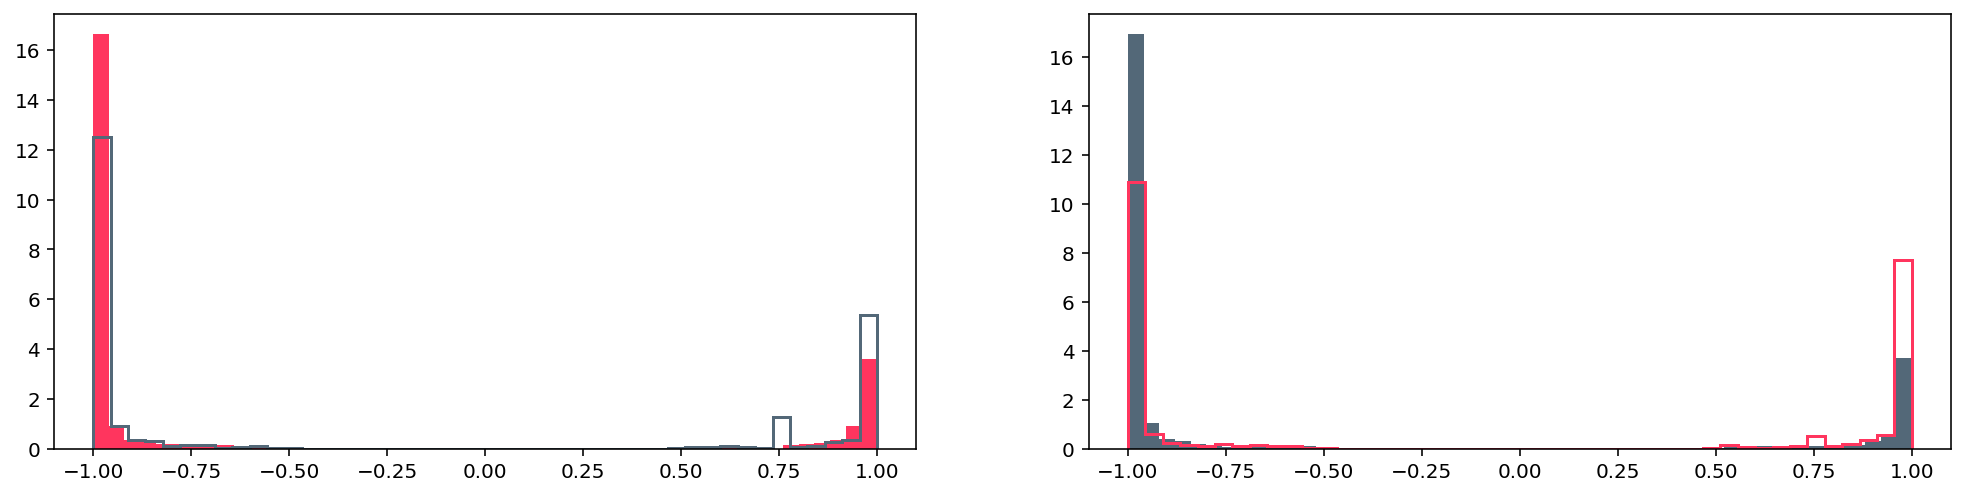

In [231]:
plt.figure(figsize = (17,4))
plt.subplot(1,2,1)
plt.hist(AM_posts_df['senti_score'], density = True, bins = 50, color = '#ff355e')
plt.hist(AM_comments_df['senti_score'], density = True, bins = 45, color = '#536878', histtype= 'step', lw = 1.5)
plt.subplot(1,2,2)
plt.hist(AW_posts_df['senti_score'], density = True, bins = 50, color = '#536878')
plt.hist(AW_comments_df['senti_score'], density = True, bins = 45, color = '#ff355e', histtype= 'step', lw = 1.5);

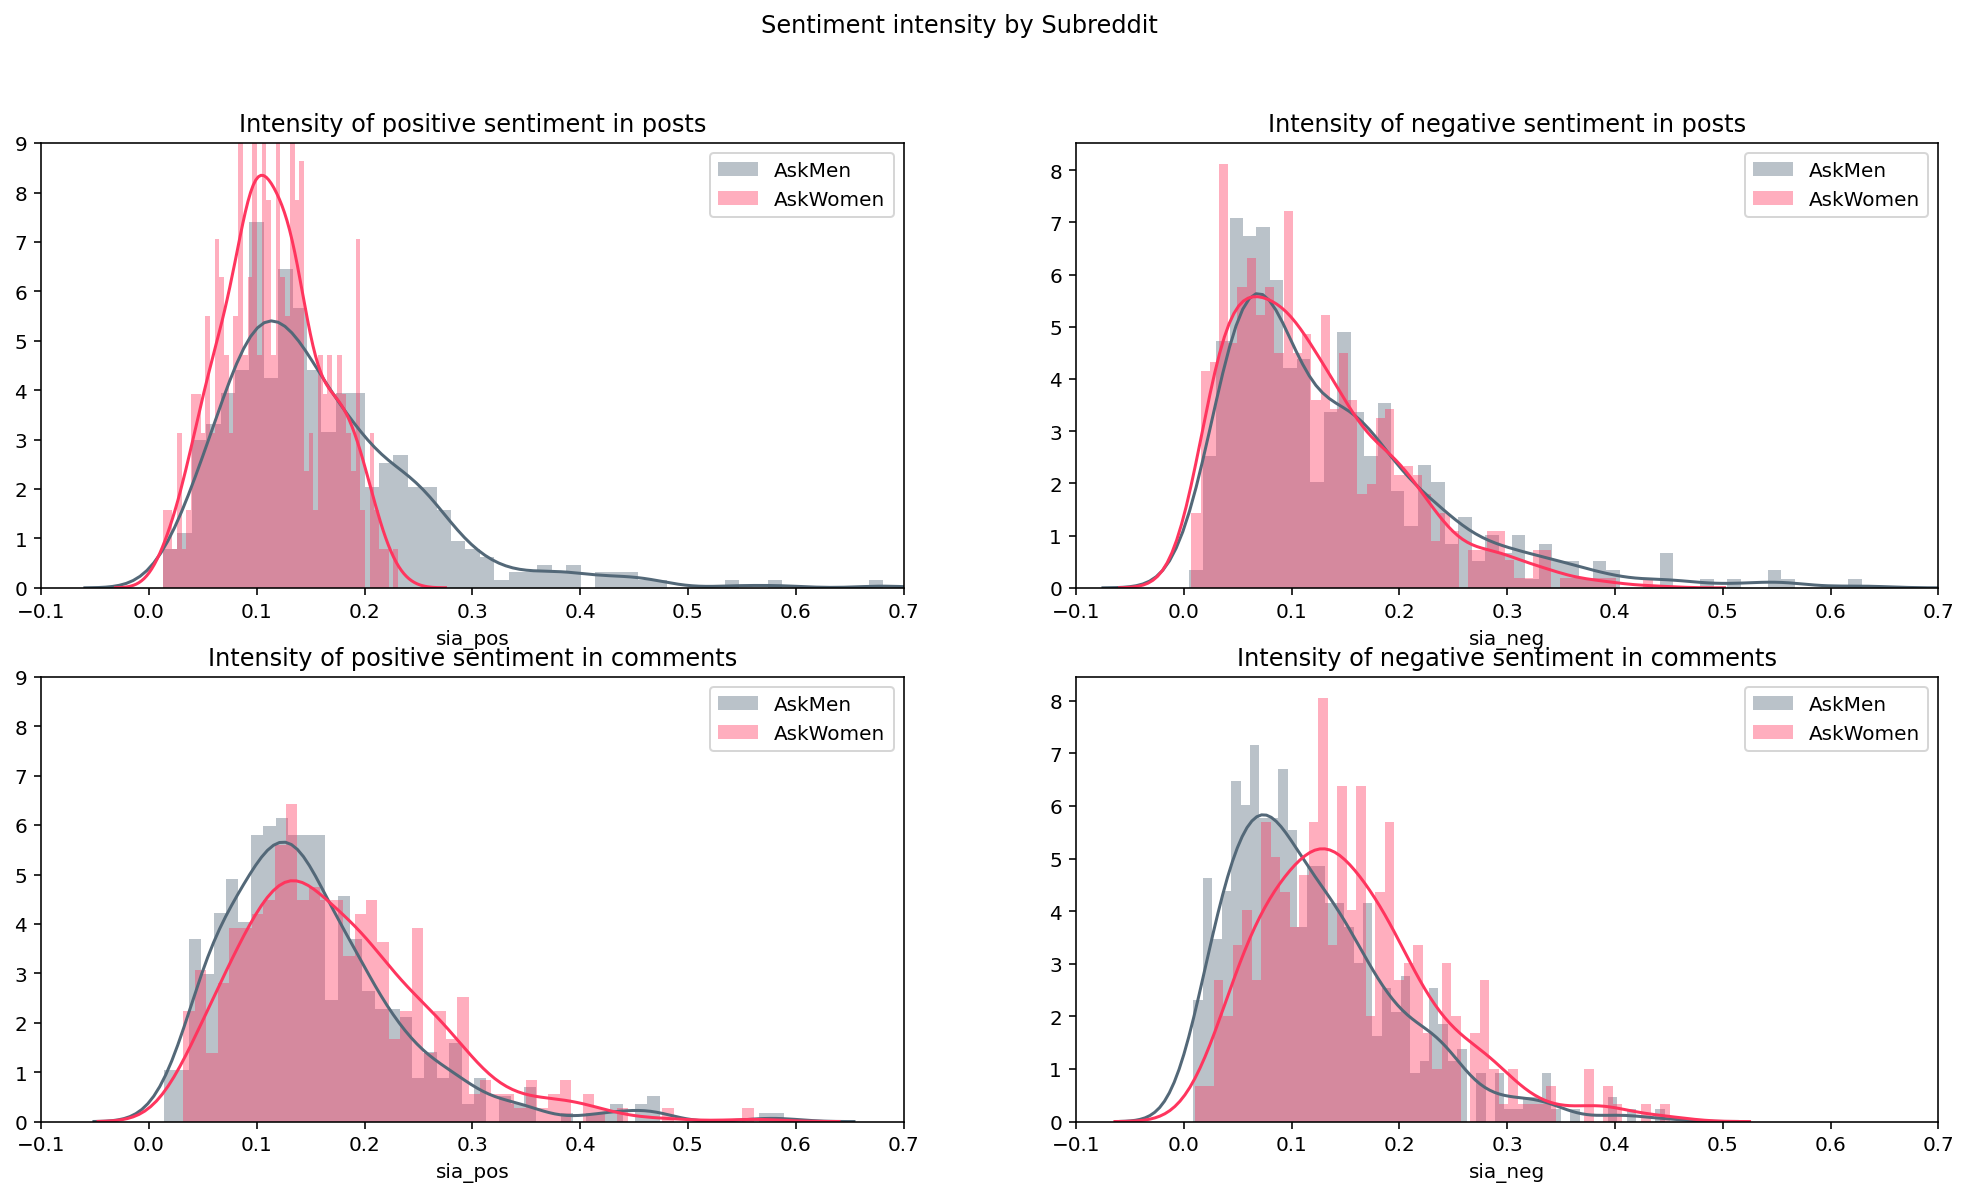

In [35]:
plt.figure(figsize = (17,9))

plt.suptitle('Sentiment intensity by Subreddit')
plt.subplot(2,2,1)
plt.title('Intensity of positive sentiment in posts')
sns.distplot(AM_comments_df[(AM_comments_df['sia_pos']!=0) & (AM_comments_df['sia_neg']!=0)]['sia_pos'], color = '#536878', bins = 50, norm_hist=True, label= 'AskMen')
sns.distplot(AM_comments_df[(AM_comments_df['sia_pos']!=0) & (AW_comments_df['sia_neg']!=0)]['sia_pos'], color = '#ff355e', bins = 50, norm_hist=True, label= 'AskWomen')
plt.legend()
plt.xlim(-.1,0.7)
plt.ylim(0,9)
plt.subplot(2,2,2)
plt.title('Intensity of negative sentiment in posts')
sns.distplot(AM_comments_df[(AM_comments_df['sia_pos']!=0) & (AM_comments_df['sia_neg']!=0)]['sia_neg'], color = '#536878', bins = 50, norm_hist=True, label= 'AskMen')
sns.distplot(AW_comments_df[(AW_comments_df['sia_pos']!=0) & (AW_comments_df['sia_neg']!=0)]['sia_neg'], color = '#ff355e', bins = 50, norm_hist=True, label= 'AskWomen')
plt.legend()
plt.xlim(-.1,0.7)
plt.subplot(2,2,3)
plt.title('Intensity of positive sentiment in comments')
sns.distplot(AM_posts_df[(AM_posts_df['sia_pos']!=0) & (AM_posts_df['sia_neg']!=0)]['sia_pos'], color = '#536878', bins = 50, norm_hist=True, label= 'AskMen')
sns.distplot(AW_posts_df[(AW_posts_df['sia_pos']!=0) & (AW_posts_df['sia_neg']!=0)]['sia_pos'], color = '#ff355e', bins = 50, norm_hist=True, label= 'AskWomen')
plt.legend()
plt.xlim(-.1,0.7)
plt.ylim(0,9)
plt.subplot(2,2,4)
plt.title('Intensity of negative sentiment in comments')
sns.distplot(AM_posts_df[(AM_posts_df['sia_pos']!=0) & (AM_posts_df['sia_neg']!=0)]['sia_neg'], color = '#536878', bins = 50, norm_hist=True, label= 'AskMen')
sns.distplot(AW_posts_df[(AW_posts_df['sia_pos']!=0) & (AW_posts_df['sia_neg']!=0)]['sia_neg'], color = '#ff355e', bins = 50, norm_hist=True, label= 'AskWomen')
plt.legend()
plt.xlim(-.1,0.7);

In [299]:
AM_posts_df = AM_posts_df.sort_values(by = 'sia_pos')
AM_comments_df = AM_comments_df.sort_values('sia_pos')
AW_posts_df = AW_posts_df.sort_values('sia_pos')
AW_comments_df = AW_comments_df.sort_values('sia_pos')

<BarContainer object of 2000 artists>

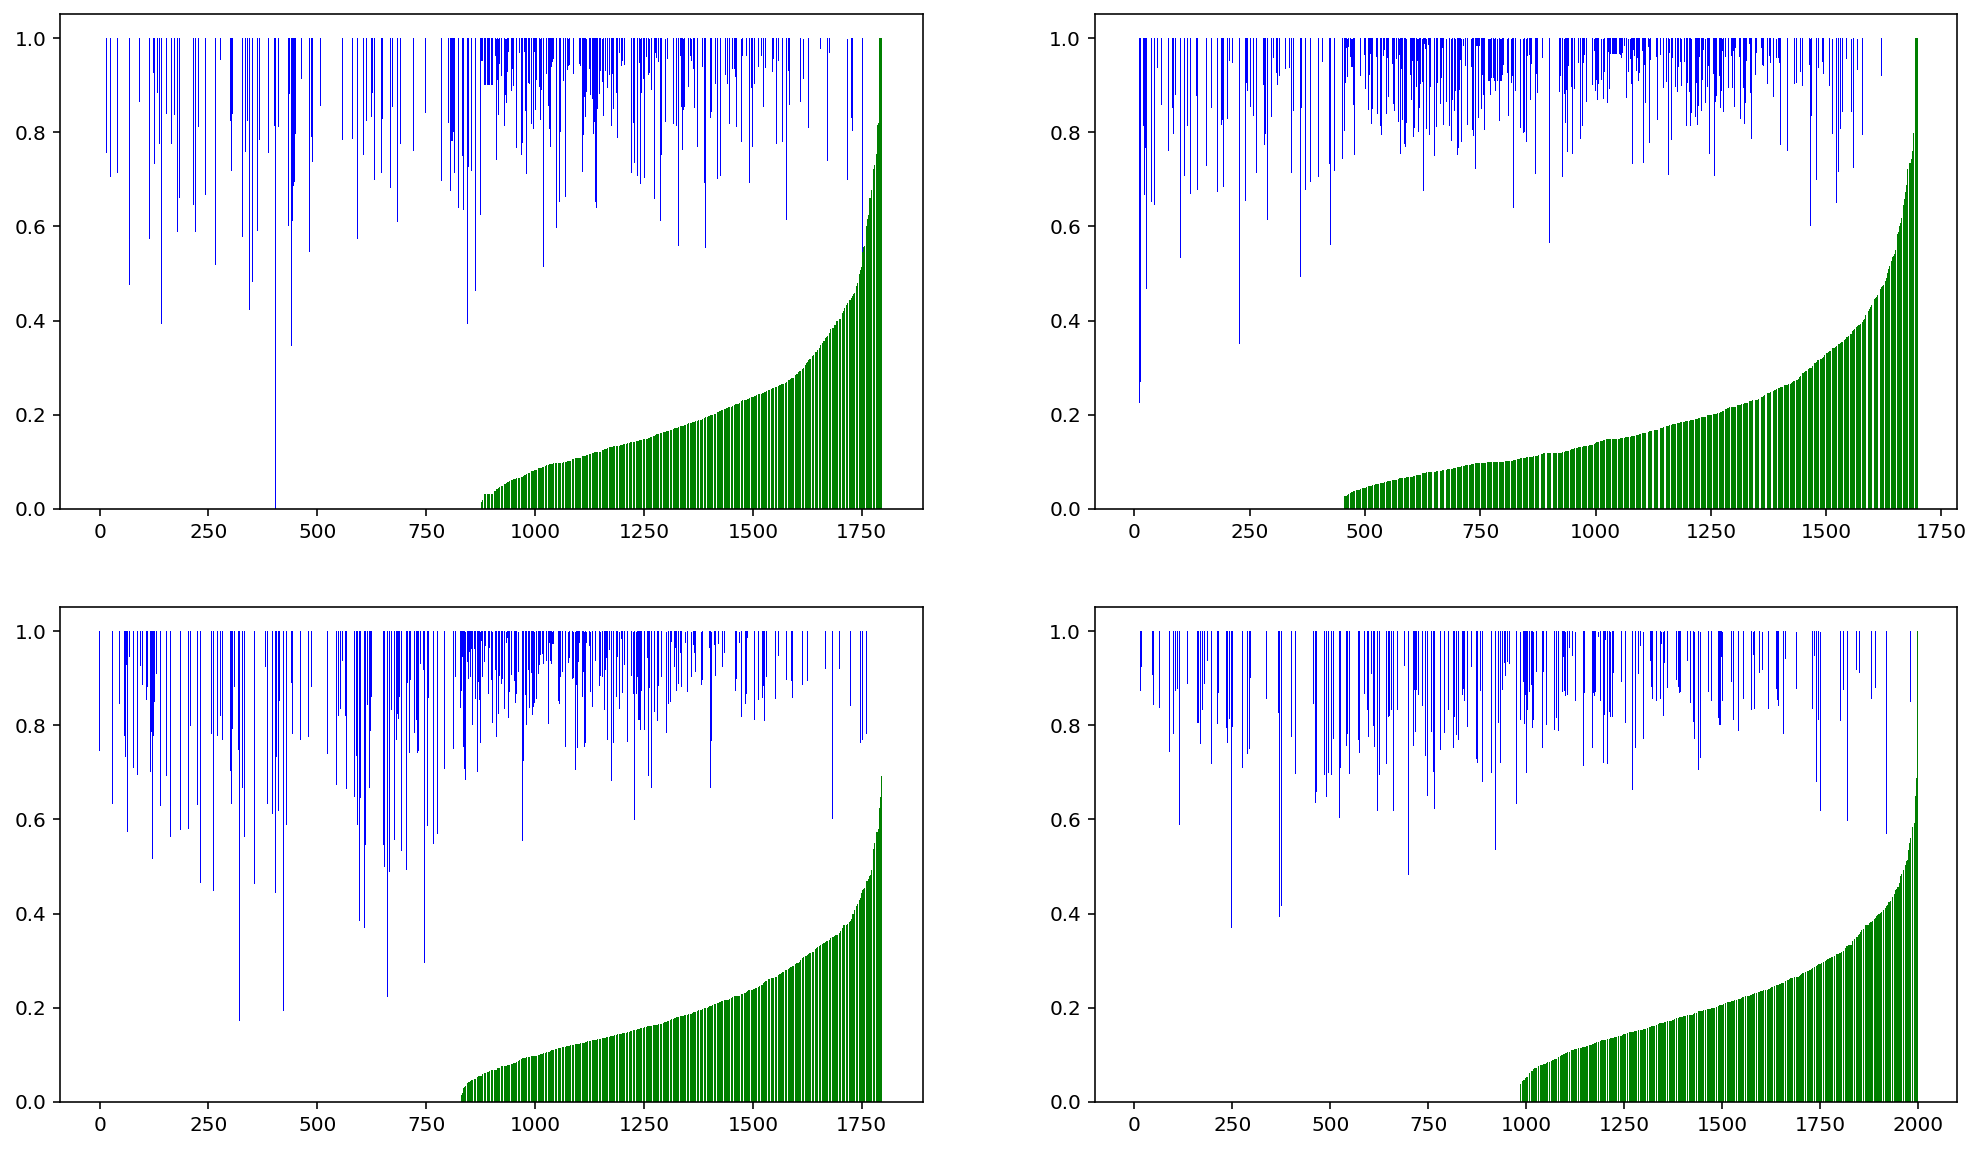

In [314]:
plt.figure(figsize=(17,10))
plt.subplot(2,2,1)
plt.bar(range(len(AM_comments_df)),AM_comments_df['sia_pos'], color = 'green')
plt.bar(range(len(AM_comments_df)),AM_comments_df['sia_neu'],bottom = AM_comments_df['sia_pos'], color = 'white')
plt.bar(range(len(AM_comments_df)),AM_comments_df['sia_neg'], bottom = AM_comments_df['sia_pos'] + AM_comments_df['sia_neu'], color = 'blue')
plt.subplot(2,2,2)
plt.bar(range(len(AW_comments_df)),AW_comments_df['sia_pos'], color = 'green')
plt.bar(range(len(AW_comments_df)),AW_comments_df['sia_neu'],bottom = AW_comments_df['sia_pos'], color = 'white')
plt.bar(range(len(AW_comments_df)),AW_comments_df['sia_neg'], bottom = AW_comments_df['sia_pos'] + AW_comments_df['sia_neu'], color = 'blue');
plt.subplot(2,2,3)
plt.bar(range(len(AM_posts_df)),AM_posts_df['sia_pos'], color = 'green')
plt.bar(range(len(AM_posts_df)),AM_posts_df['sia_neu'],bottom = AM_posts_df['sia_pos'], color = 'white')
plt.bar(range(len(AM_posts_df)),AM_posts_df['sia_neg'], bottom = AM_posts_df['sia_pos'] + AM_posts_df['sia_neu'], color = 'blue')
plt.subplot(2,2,4)
plt.bar(range(len(AW_posts_df)),AW_posts_df['sia_pos'], color = 'green')
plt.bar(range(len(AW_posts_df)),AW_posts_df['sia_neu'], bottom = AW_posts_df['sia_pos'], color = 'white')
plt.bar(range(len(AW_posts_df)),AW_posts_df['sia_neg'], bottom = AW_posts_df['sia_pos'] + AW_posts_df['sia_neu'], color = 'blue')

In [42]:
AW_comments_df.to_csv('aw_com.csv')
AW_posts_df.to_csv('aw_pos.csv')
AM_comments_df.to_csv('am_com.csv')
AM_posts_df.to_csv('am_pos.csv')

**EXPLORATORY ANALYSIS**

In [9]:
AM_posts_df['len_chars'] = AM_posts_df['title_selftext'].apply(lambda x: len(str(x)))
AM_posts_df['len_words'] = AM_posts_df['title_selftext'].apply(lambda x: str(x).count(' '))
AM_posts_df['avg_word_chars'] = AM_posts_df['len_chars']/AM_posts_df['len_words']
AW_posts_df['len_chars'] = AW_posts_df['title_selftext'].apply(lambda x: len(str(x)))
AW_posts_df['len_words'] = AW_posts_df['title_selftext'].apply(lambda x: str(x).count(' '))
AW_posts_df['avg_word_chars'] = AW_posts_df['len_chars']/AW_posts_df['len_words']

AM_comments_df['len_chars'] = AM_comments_df['body'].apply(lambda x: len(str(x)))
AM_comments_df['len_words'] = AM_comments_df['body'].apply(lambda x: str(x).count(' '))
AM_comments_df['avg_word_chars'] = AM_comments_df['len_chars']/AM_comments_df['len_words']
AW_comments_df['len_chars'] = AW_comments_df['body'].apply(lambda x: len(str(x)))
AW_comments_df['len_words'] = AW_comments_df['body'].apply(lambda x: str(x).count(' '))
AW_comments_df['avg_word_chars'] = AW_comments_df['len_chars']/AW_comments_df['len_words']

In [ ]:
# print(AM_posts_df['len_chars'].mean())
# print(AM_posts_df['len_words'].mean())
# print(AM_posts_df['avg_word_chars'].median())
# print(AW_posts_df['len_chars'].mean())
# print(AW_posts_df['len_words'].mean())
# print(AW_posts_df['avg_word_chars'].median())

# print(AM_comments_df['len_chars'].mean())
# print(AM_comments_df['len_words'].mean())
# print(AM_comments_df['avg_word_chars'].median())
# print(AW_comments_df['len_chars'].mean())
# print(AW_comments_df['len_words'].mean())
# print(AW_comments_df['avg_word_chars'].median())

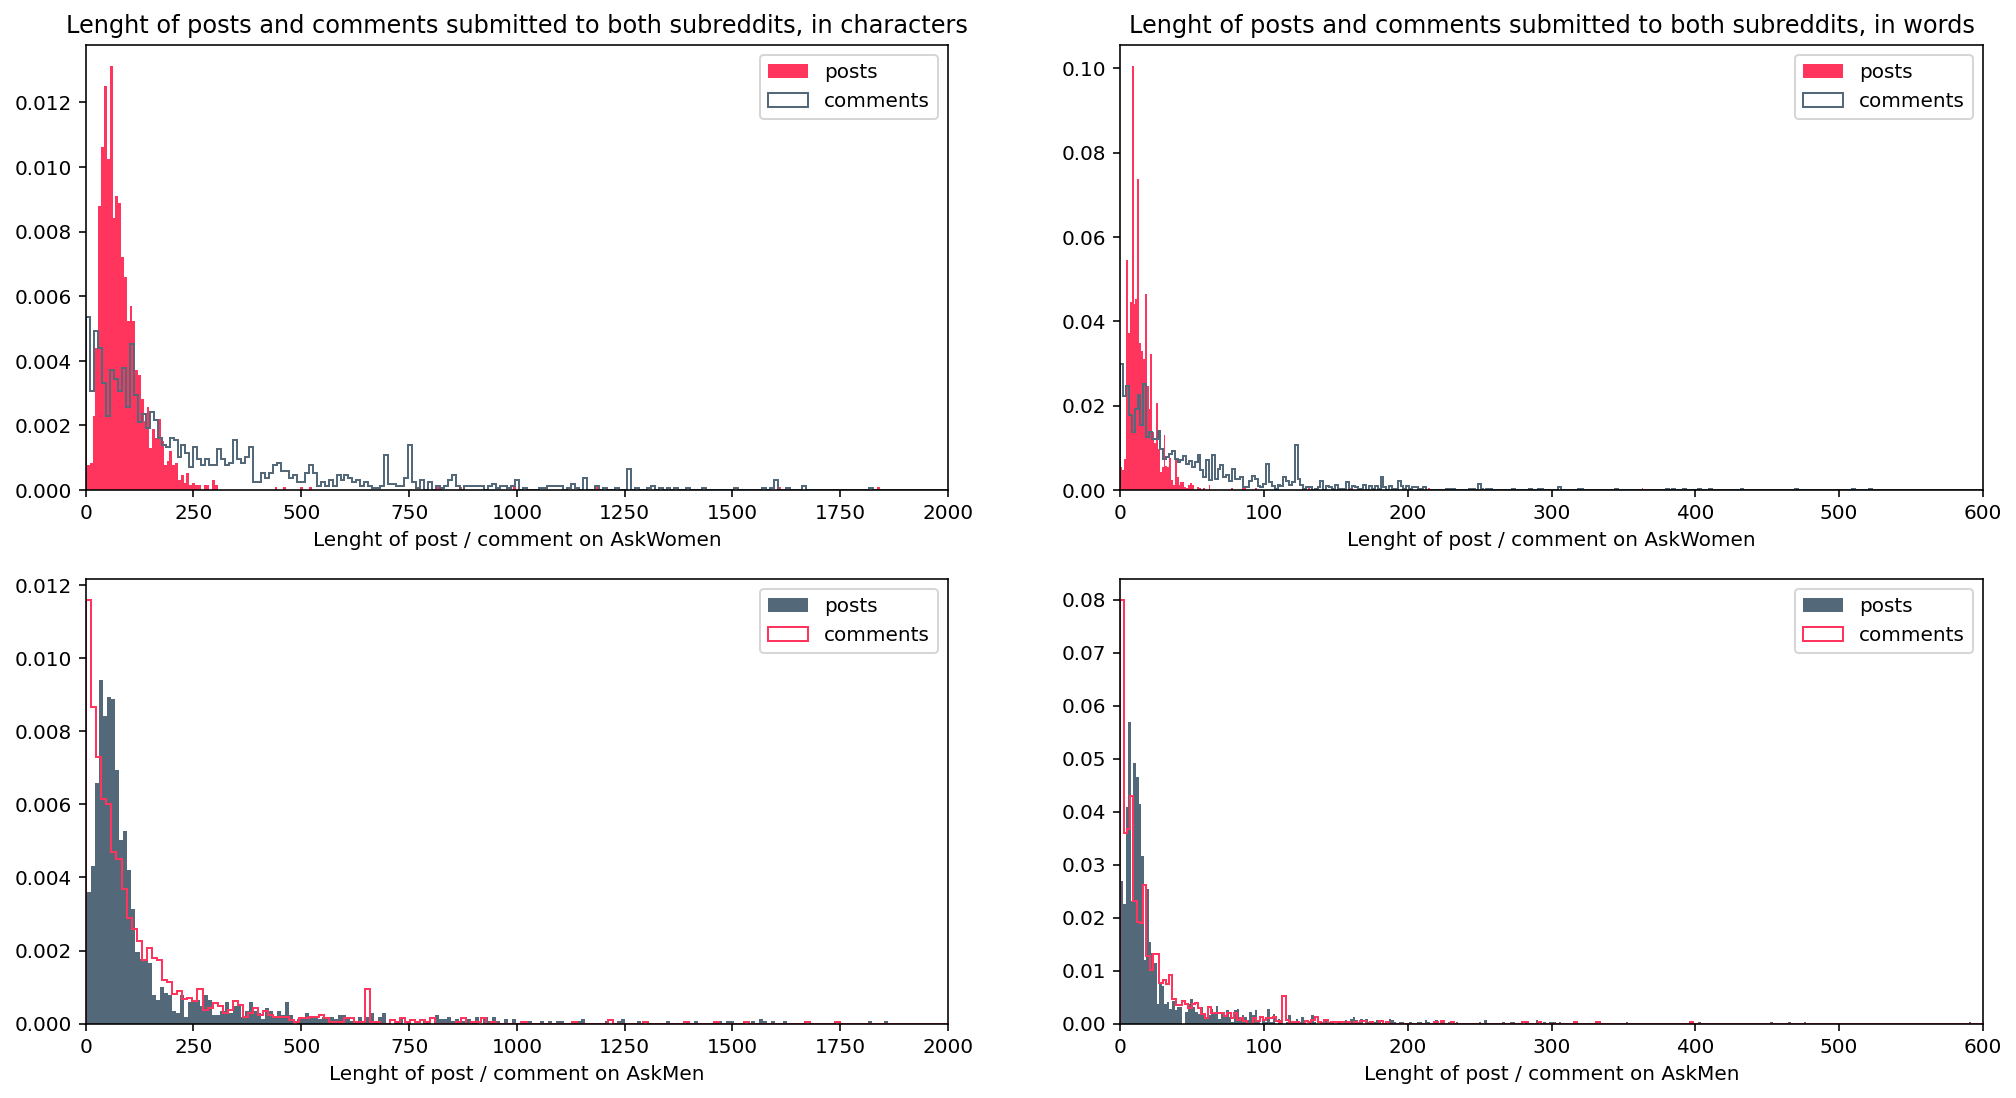

In [210]:
plt.figure(figsize = (17,9))
plt.subplot(2,2,1)
plt.title('Lenght of posts and comments submitted to both subreddits, in characters')
plt.hist(AW_posts_df['len_chars'], color = '#ff355e', label = 'posts', bins = 500, density = True)
plt.hist(AW_comments_df['len_chars'], color = '#536878', histtype= 'step', lw = 1, label = 'comments', bins = 500, density = True)
plt.xlim(0,2000)
plt.xlabel('Lenght of post / comment on AskWomen')
plt.legend()
plt.subplot(2,2,3)
plt.hist(AM_posts_df['len_chars'], color = '#536878', label = 'posts', bins = 500, density = True)
plt.hist(AM_comments_df['len_chars'], color = '#ff355e', histtype= 'step', lw = 1, label = 'comments', bins = 500, density = True)
plt.xlim(0,2000)
plt.xlabel('Lenght of post / comment on AskMen')
plt.legend()
plt.subplot(2,2,2)
plt.title('Lenght of posts and comments submitted to both subreddits, in words')
plt.hist(AW_posts_df['len_words'], color = '#ff355e', label = 'posts', bins = 500, density = True)
plt.hist(AW_comments_df['len_words'], color = '#536878', histtype= 'step', lw = 1, label = 'comments', bins = 500, density = True)
plt.xlim(0,600)
plt.xlabel('Lenght of post / comment on AskWomen')
plt.legend()
plt.subplot(2,2,4)
plt.hist(AM_posts_df['len_words'], color = '#536878', label = 'posts', bins = 500, density = True)
plt.hist(AM_comments_df['len_words'], color = '#ff355e', histtype= 'step', lw = 1, label = 'comments', bins = 500, density = True)
plt.xlim(0,600)
plt.xlabel('Lenght of post / comment on AskMen')
plt.legend();
plt.savefig('./visualizations/lenghts.png')

In [84]:
AW_comments_df['len_chars'].describe()

count    1700.000000
mean      272.797059
std       344.060838
min         1.000000
25%        65.750000
50%       150.500000
75%       349.000000
max      4611.000000
Name: len_chars, dtype: float64

In [75]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
AM_tokens = word_tokenize(AM_posts_corpus.lower()+AM_comments_corpus.lower())
AM_stem_tokens = [stemmer.stem(token) for token in AM_tokens]
AM_stem_tokens_no_stops = [token for token in AM_stem_tokens if not token in stops]

In [74]:
AW_tokens = word_tokenize(AW_posts_corpus.lower()+AW_comments_corpus.lower())
AW_stem_tokens = [stemmer.stem(token) for token in AW_tokens]
AW_stem_tokens_no_stops = [token for token in AW_stem_tokens if not token in stops]

In [69]:
'“' in AW_stem_tokens_no_stops

True

In [72]:
stops.extend('“')

In [73]:
'“' in stops

True

In [95]:
# AM_most_common_words = set([word for word, ct in FreqDist(AM_stem_tokens_no_stops).most_common(100)])
# AW_most_common_words = set([word for word, ct in FreqDist(AW_stem_tokens_no_stops).most_common(100)])

# AW_and_AM = set.intersection(AW_most_common_words, AM_most_common_words)

AM_most_common_words = set([word for word, ct in FreqDist(AM_stem_tokens_no_stops).most_common(50)])
AW_most_common_words = set([word for word, ct in FreqDist(AW_stem_tokens_no_stops).most_common(50)])

AW_and_AM = set.union(AW_most_common_words, AM_most_common_words)

In [96]:
common_words = pd.DataFrame(np.array([list(AW_and_AM), [-FreqDist(AM_stem_tokens_no_stops)[word] for word in AW_and_AM],
                             [FreqDist(AW_stem_tokens_no_stops)[word] for word in AW_and_AM]]).T, 
                             columns = ['word', 'AM', 'AW'])

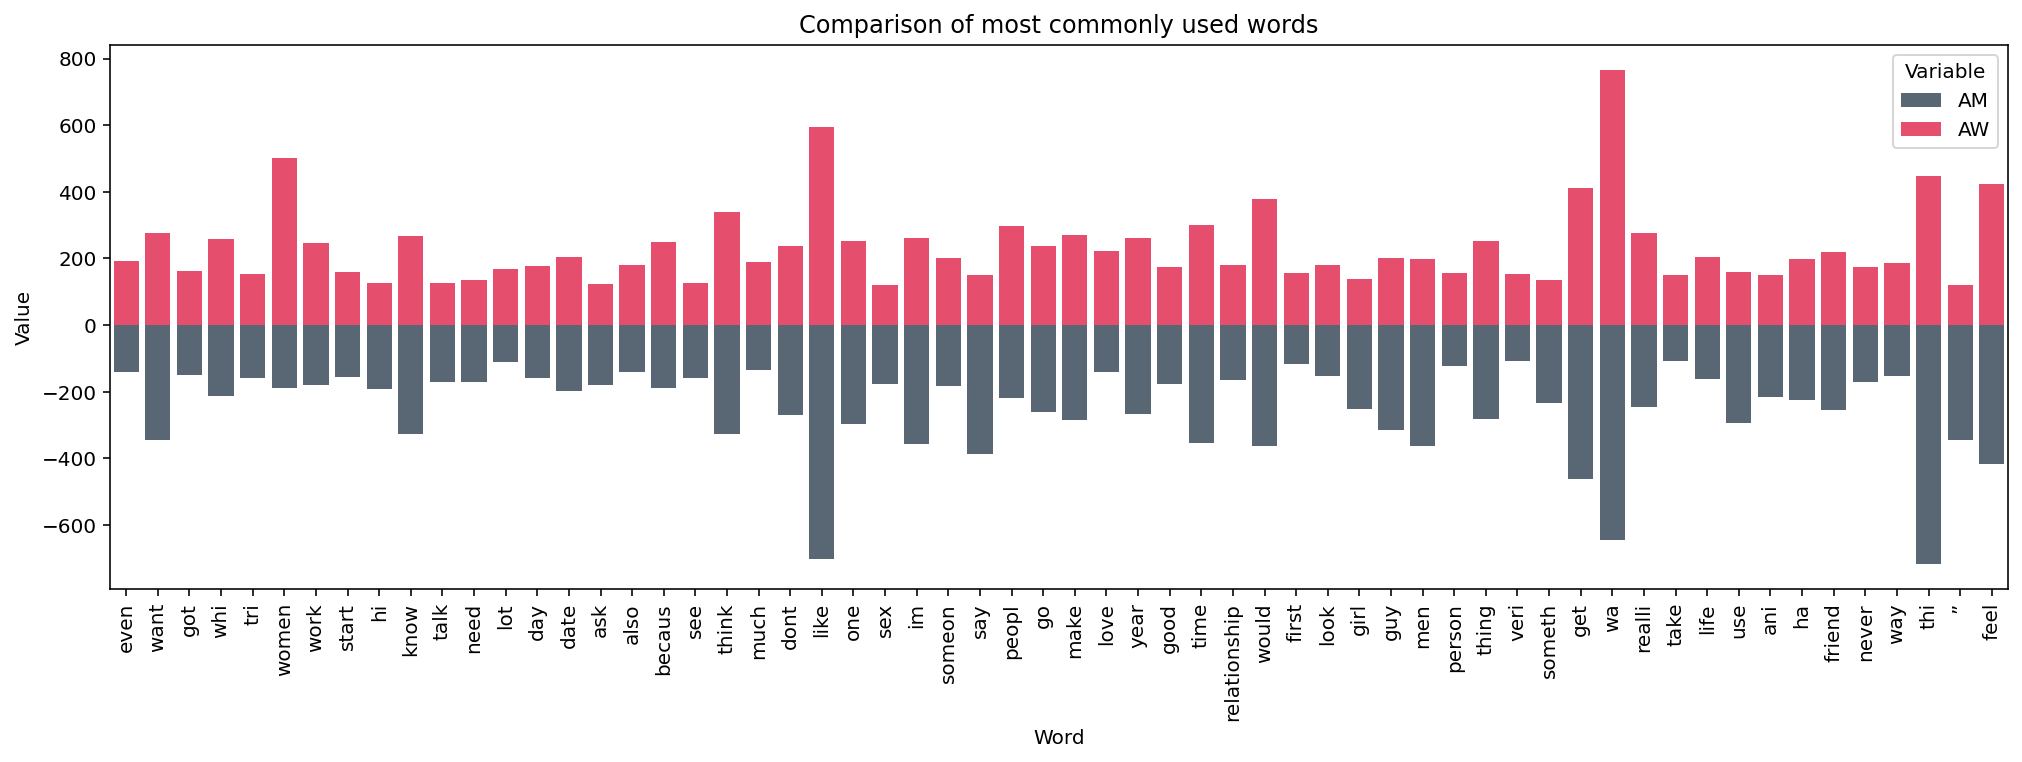

In [97]:
fig, ax1 = plt.subplots(figsize=(17,5))
tidy = common_words.melt(id_vars='word').rename(columns=str.title)
sns.barplot(x='Word', y='Value', hue='Variable', data=tidy, ax = ax1, dodge = False, palette = ['#536878','#ff355e'])
plt.title('Comparison of most commonly used words')
plt.xticks(rotation = 90);
plt.savefig('./visualizations/common_words.png')

In [169]:
AM_most_common.difference(AW_and_AM)

{'actual',
 'anyth',
 'attract',
 'better',
 'call',
 'come',
 'everi',
 'give',
 'happen',
 'ive',
 'keep',
 'kid',
 'mean',
 'old',
 'reason',
 'right',
 'said',
 'sinc',
 'son',
 'us',
 'well',
 'woman',
 'wrong'}

In [170]:
AW_most_common.difference(AW_and_AM)

{'action',
 'advic',
 'amp',
 'askwomen',
 'care',
 'click',
 'comment',
 'content',
 'els',
 'experi',
 'famili',
 'includ',
 'link',
 'made',
 'messag',
 'moder',
 'mom',
 'pleas',
 'post',
 'read',
 'respons',
 'rule',
 'submiss'}

In [76]:
AW_bigrams = list(ngrams(AW_stem_tokens_no_stops,2))
FreqDist(AW_bigrams)

FreqDist({('feel', 'like'): 85, ('women', 'reddit'): 64, ('thi', 'year'): 38, ('make', 'feel'): 38, ('year', 'old'): 27, ('whi', 'women'): 26, ('everi', 'day'): 25, ('dont', 'know'): 24, ('first', 'time'): 23, ('mental', 'health'): 23, ...})

In [77]:
AM_bigrams = list(ngrams(AM_stem_tokens_no_stops,2))
FreqDist(AM_bigrams)

FreqDist({('feel', 'like'): 96, ('men', 'reddit'): 67, ('year', 'old'): 53, ('dont', 'know'): 46, ('like', 'thi'): 35, ('wan', 'na'): 32, ('gon', 'na'): 32, ('thi', 'year'): 30, ('dont', 'want'): 28, ('make', 'feel'): 27, ...})

In [98]:
# AM_most_common_bi = set([bi for bi, ct in FreqDist(ngrams(AM_stem_tokens_no_stops,2)).most_common(100)])
# AW_most_common_bi = set([bi for bi, ct in FreqDist(ngrams(AW_stem_tokens_no_stops,2)).most_common(100)])

# AW_and_AM_bi = set.intersection(AW_most_common_bi, AM_most_common_bi)

AM_most_common_bi = set([bi for bi, ct in FreqDist(ngrams(AM_stem_tokens_no_stops,2)).most_common(50)])
AW_most_common_bi = set([bi for bi, ct in FreqDist(ngrams(AW_stem_tokens_no_stops,2)).most_common(50)])

AW_and_AM_bi = set.union(AW_most_common_bi, AM_most_common_bi)

In [99]:
common_bis = pd.DataFrame(np.array([list(AW_and_AM_bi), 
                            [-FreqDist(ngrams(AM_stem_tokens_no_stops,2))[bi] for bi in AW_and_AM_bi],
                            [FreqDist(ngrams(AW_stem_tokens_no_stops,2))[bi] for bi in AW_and_AM_bi]]).T, 
                             columns = ['bigram', 'AM', 'AW'])

<ipython-input-99-03db1970efd8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  common_bis = pd.DataFrame(np.array([list(AW_and_AM_bi),


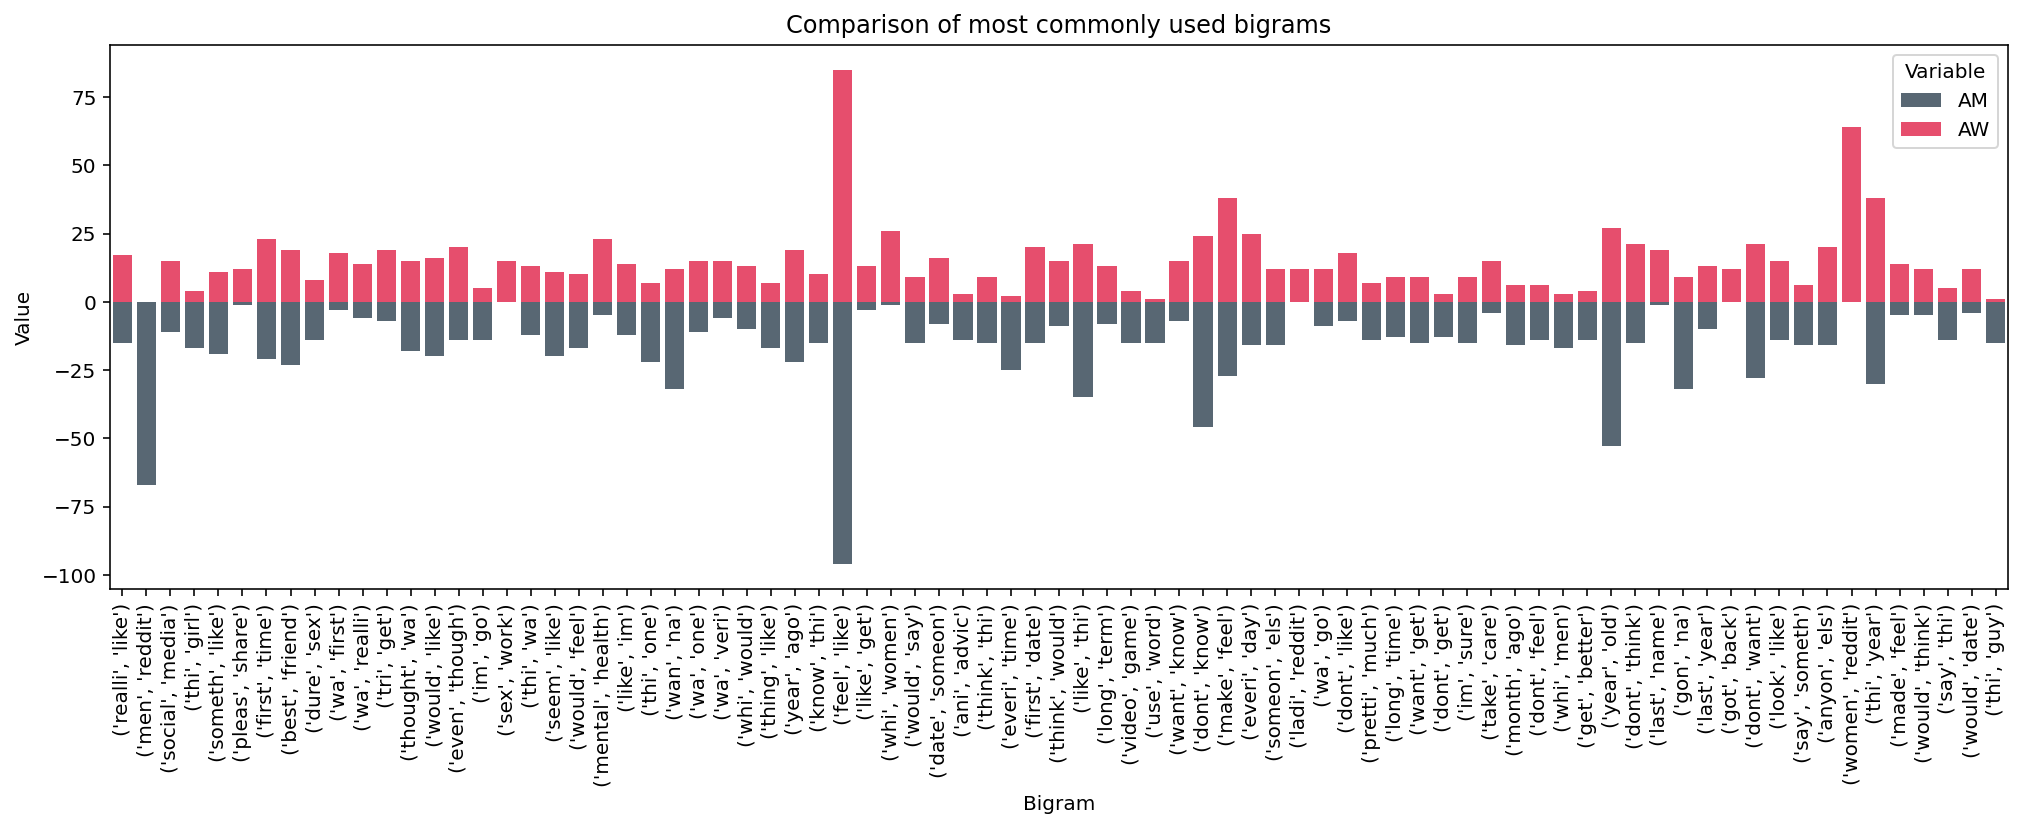

In [100]:
fig, ax1 = plt.subplots(figsize=(17,5))
tidy = common_bis.melt(id_vars='bigram').rename(columns=str.title)
sns.barplot(x='Bigram', y='Value', hue='Variable', data=tidy, ax = ax1, dodge = False, palette = ['#536878','#ff355e'])
plt.title('Comparison of most commonly used bigrams')
plt.xticks(rotation = 90);
plt.savefig('./visualizations/common_bigrams.png')

In [78]:
AW_trigrams = list(ngrams(AW_stem_tokens_no_stops,3)) #AW_stem_tokens_no_stops
FreqDist(AW_trigrams)

FreqDist({('feel', 'like', 'im'): 7, ('got', 'back', 'togeth'): 7, ('long', 'term', 'relationship'): 6, ('legal', 'sex', 'work'): 6, ('would', 'date', 'man'): 5, ('delet', 'social', 'media'): 5, ('feel', 'thi', 'way'): 5, ('make', 'feel', 'bad'): 5, ('birth', 'control', 'pill'): 4, ('doe', 'anyon', 'els'): 4, ...})

In [79]:
AM_trigrams = list(ngrams(AM_stem_tokens_no_stops,3))
FreqDist(AM_trigrams)

FreqDist({('play', 'video', 'game'): 10, ('amp', '#', 'xb'): 9, ('year', 'old', 'dad'): 7, ('im', 'year', 'old'): 6, ('men', 'reddit', 'doe'): 6, ('advic', 'would', 'give'): 6, ('feel', 'like', 'im'): 6, ('remain', 'friend', 'ex'): 6, ('ai', 'ai', 'dungeon'): 6, ('ai', 'dungeon', 'sexi'): 6, ...})

In [101]:
# AM_most_common_tri = set([tri for tri, ct in FreqDist(ngrams(AM_stem_tokens_no_stops,3)).most_common(100)])
# AW_most_common_tri = set([tri for tri, ct in FreqDist(ngrams(AW_stem_tokens_no_stops,3)).most_common(100)])

# AW_and_AM_tri = set.intersection(AW_most_common_tri, AM_most_common_tri)

AM_most_common_tri = set([tri for tri, ct in FreqDist(ngrams(AM_stem_tokens_no_stops,3)).most_common(50)])
AW_most_common_tri = set([tri for tri, ct in FreqDist(ngrams(AW_stem_tokens_no_stops,3)).most_common(50)])

AW_and_AM_tri = set.union(AW_most_common_tri, AM_most_common_tri)

In [102]:
common_tris = pd.DataFrame(np.array([list(AW_and_AM_tri), 
                                     [-FreqDist(ngrams(AM_stem_tokens_no_stops,3))[tri] for tri in AW_and_AM_tri],
                                      [FreqDist(ngrams(AW_stem_tokens_no_stops,3))[tri] for tri in AW_and_AM_tri]]).T, 
                                     columns = ['trigram', 'AM', 'AW'])

<ipython-input-102-52334ec0766e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  common_tris = pd.DataFrame(np.array([list(AW_and_AM_tri),


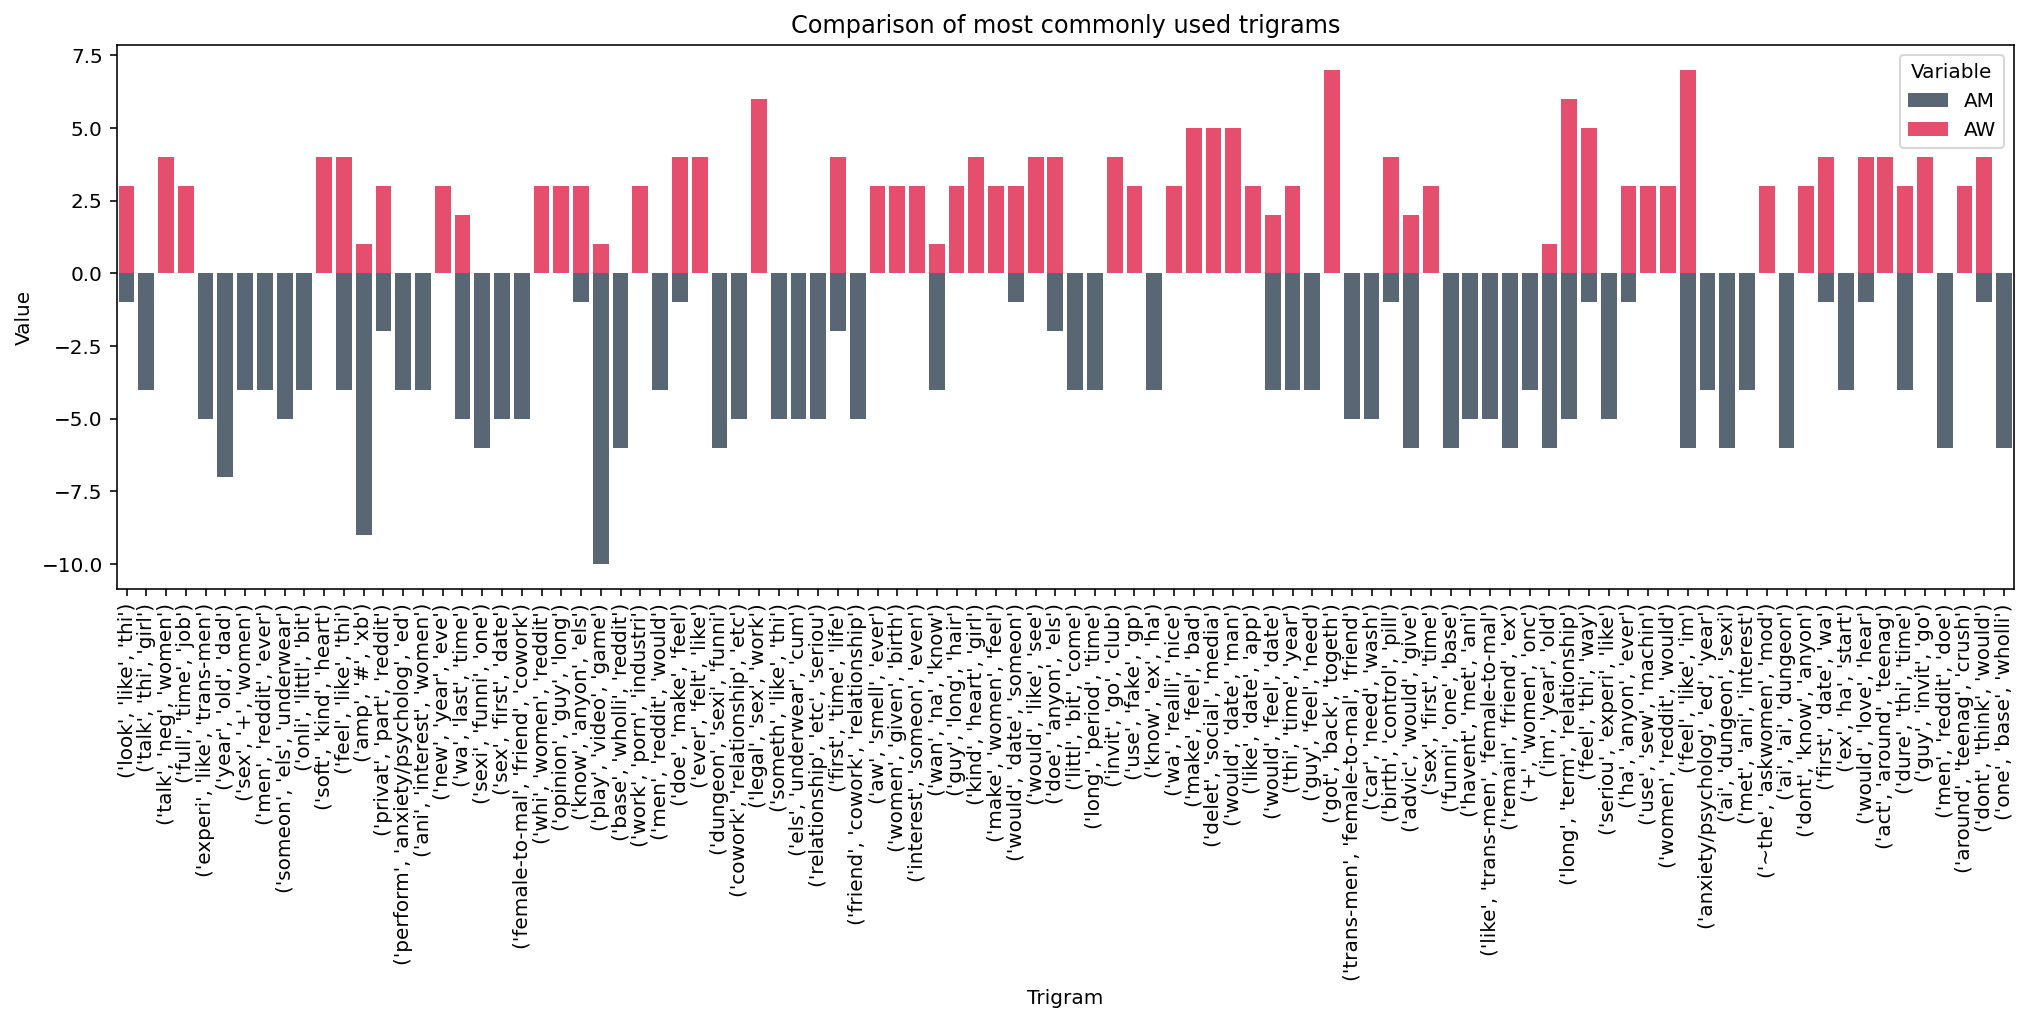

In [103]:
fig, ax1 = plt.subplots(figsize=(17,5))
tidy = common_tris.melt(id_vars='trigram').rename(columns=str.title)
sns.barplot(x='Trigram', y='Value', hue='Variable', data=tidy, ax = ax1, dodge = False, palette = ['#536878','#ff355e'])
plt.title('Comparison of most commonly used trigrams')
plt.xticks(rotation = 90);
plt.savefig('./visualizations/common_trigrams.png')

In [48]:
AW_vocabulary = sorted(list(set((AW_posts_corpus+AW_comments_corpus).lower().split())))
AM_vocabulary = sorted(list(set((AM_posts_corpus+AM_comments_corpus).lower().split())))

print("=========AskMen=========")
print(len(AM_vocabulary))
print("\n========AskWomen========")
print(len(AW_vocabulary))

=========AskMen=========
14904

========AskWomen========
14490


In [72]:
import emoji

def extract_emojis(s):
  return [c for c in s if c in emoji.UNICODE_EMOJI]

In [73]:
AW_emojis = set(extract_emojis(AW_posts_corpus+AW_comments_corpus))
AM_emojis = set(extract_emojis(AM_posts_corpus+AM_comments_corpus))

In [14]:
print(f"AskWomen posts and comments feature {len(AW_emojis)} emojis: {AW_emojis}")

AskWomen posts and comments feature 49 emojis: {'🤥', '🥺', '🤣', '😯', '🥰', '💕', '😅', '😳', '😊', '👀', '🤷', '🏻', '👇', '🎅', '🙏', '💥', '🙂', '🏾', '🙄', '❤', '💍', '✋', '🌚', '🤦', '🎁', '💚', '🥴', '😋', '🎄', '❓', '♀', '☺', '♥', '🙃', '🤔', '😔', '🤢', '😂', '😭', '👰', '😍', '😱', '💖', '🤡', '😆', '💁', '🏼', '🤭', '✨'}


In [15]:
print(f"AskMen posts and comments feature {len(AM_emojis)} emojis: {AM_emojis}")

AskMen posts and comments feature 165 emojis: {'😝', '💩', '🧐', '👶', '🉐', '🌄', '💕', '🤷', '🙌', '🏻', '🌈', '🤚', '🐣', '🚴', '🙈', '✅', '🌙', '🎄', '❓', '🤔', '🐾', '💨', '😭', '🌎', '🤞', '🐝', '🍻', '😱', '👉', '👈', '🇦', '😃', '🗣', '🔗', '🍆', '😈', '👬', '👧', '👭', '✔', '🚬', '⚰', '🏃', '😠', '👅', '⏰', '💼', '👊', '😌', '📅', '🔚', '🇵', '🏾', '💬', '😀', '😏', '☀', '📷', '❔', '👫', '🚶', '💅', '♀', '👌', '🚡', '😔', '👣', '👋', '💹', '🤫', '⬆', '🎼', '👪', '🏘', '💓', '🏽', '🙇', '🍓', '📖', '😤', '💢', '🥶', '🌾', '🤣', '💯', '🙀', '😒', '💪', '🧔', '👁', '👀', '👴', '🏫', '👇', '🙏', '💥', '🔫', '❎', '🚨', '🙄', '🍂', '✋', '🌞', '😜', '😐', '🏿', '🏳', '😩', '👩', '👵', '🍑', '💰', '👱', '😮', '😓', '😆', '🏼', '🌬', '🙅', '🔥', '🎣', '✨', '👥', '💔', '🚫', '🕛', '🎤', '😬', '💦', '❄', '🌪', '🤽', '🏊', '😯', '👍', '☝', '😢', '👦', '📦', '🔔', '🔁', '👻', '🌹', '💀', '🚯', '❤', '✊', '🐰', '❌', '📆', '👨', '📝', '🧠', '🚑', '😂', '📒', '♂', '🔍', '📼', '🌟', '🕺', '🤡', '🏄', '😎', '🤠'}


In [158]:
emoji.UNICODE_EMOJI['🚫']

':prohibited:'

In [190]:
AM_emojis_freq = {emo: (AM_posts_corpus+AM_comments_corpus).count(emo) for emo in AM_emojis}
AW_emojis_freq = {emo: (AW_posts_corpus+AW_comments_corpus).count(emo) for emo in AW_emojis}
emos = list(set([emo for emo in AM_emojis_freq.keys() if AM_emojis_freq[emo]>= 3]+[emo for emo in AW_emojis_freq.keys() if AW_emojis_freq[emo]>= 3]))

In [319]:
emos_chart = pd.DataFrame(np.array([[emoji.UNICODE_EMOJI[emo] for emo in emos], 
                                    [-AM_emojis_freq.setdefault(emo,0) for emo in emos],
                                     [AW_emojis_freq.setdefault(emo,0) for emo in emos]]).T, 
                                     columns = ['descr', 'AM', 'AW'])

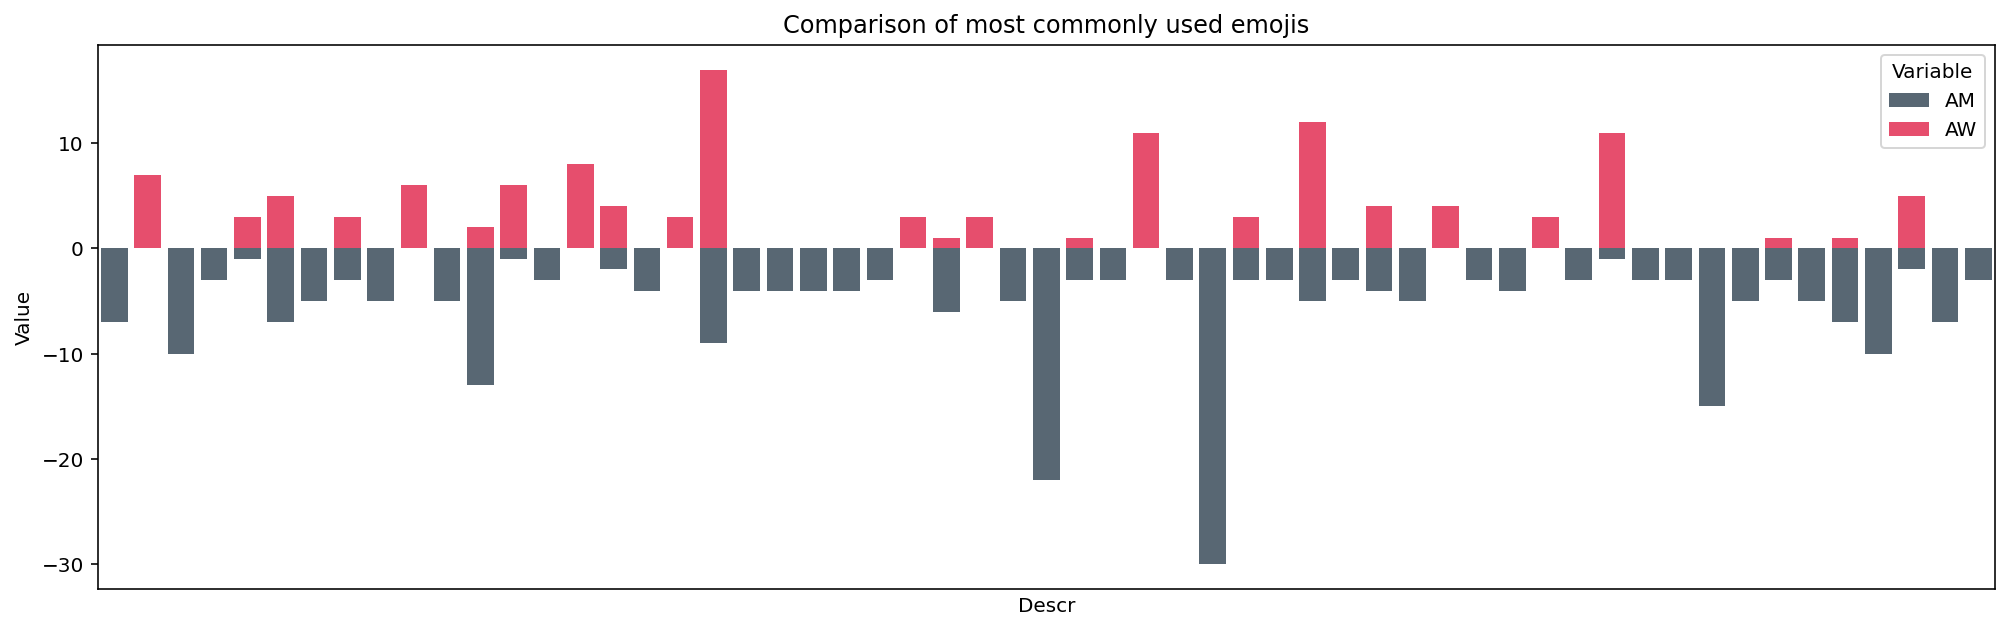

In [201]:

from matplotlib.font_manager import FontProperties
prop = FontProperties(fname='/System/Library/Fonts/Apple Color Emoji.ttc')
fig, ax1 = plt.subplots(figsize=(17,5))
tidy = emos_chart.melt(id_vars='descr').rename(columns=str.title)
sns.barplot(x='Descr', y='Value', hue='Variable', data=tidy,  dodge = False, palette = ['#536878','#ff355e'])
plt.title('Comparison of most commonly used emojis')
plt.xticks([]);
plt.savefig('./visualizations/common_emojis.png')

In [196]:
" ".join(emos)

'🚫 🥺 💯 😎 🏾 🏼 👥 🤔 👍 😅 🚶 🏻 ♀ 👬 😍 😭 👌 ☺ 😂 👊 👦 💪 😌 🐰 🥰 👀 😳 💨 👨 ✋ 🔫 ♥ 🙌 👁 🙄 🙀 🤣 🗣 🙏 😩 🤭 👉 🍆 🌚 🏫 ❤ 👈 🔁 💦 ❌ 😔 😈 💥 ♂ 🤷 😀 🙅'

In [321]:
AW_posts_df['emojis'] = AW_posts_df['title_selftext'].apply(lambda x: sum([1 for c in str(x) if c in emoji.UNICODE_EMOJI]))
AM_posts_df['emojis'] = AM_posts_df['title_selftext'].apply(lambda x: sum([1 for c in str(x) if c in emoji.UNICODE_EMOJI]))
AW_comments_df['emojis'] = AW_comments_df['body'].apply(lambda x: sum([1 for c in str(x) if c in emoji.UNICODE_EMOJI]))
AM_comments_df['emojis'] = AM_comments_df['body'].apply(lambda x: sum([1 for c in str(x) if c in emoji.UNICODE_EMOJI]))

In [261]:
AW_posts_df['emojis'].describe()

count    2000.000000
mean        0.019500
std         0.249301
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.000000
Name: emojis, dtype: float64

In [262]:
AM_posts_df['emojis'].describe()

count    1800.000000
mean        0.013333
std         0.255762
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: emojis, dtype: float64

In [70]:
dfs = [AW_posts_df, AM_posts_df, AM_comments_df, AW_comments_df]
for df in dfs:
    df['created_yr'] = df['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).replace(tzinfo=datetime.timezone.utc).year)
    df['created_mth'] = df['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).replace(tzinfo=datetime.timezone.utc).month)
    df['created_dy'] = df['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).replace(tzinfo=datetime.timezone.utc).day)
    df['created_hr'] = df['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).replace(tzinfo=datetime.timezone.utc).hour)

In [78]:
AM_posts_df['created_utc'].describe().astype(int)

count          1800
mean     1609014286
std          112369
min      1608800712
25%      1608919970
50%      1609027996
75%      1609111573
max      1609186931
Name: created_utc, dtype: int64

### Classification based only on content (incl. comments)

In [272]:
text_subreddit = pd.concat([AW_posts_df[['title_selftext', 'subreddit']], AW_comments_df[['body', 'subreddit']], 
               AM_posts_df[['title_selftext', 'subreddit']], AM_comments_df[['body', 'subreddit']]], axis = 0)

text_subreddit['title_selftext'] = text_subreddit['title_selftext'].fillna("")
text_subreddit['body'] = text_subreddit['body'].fillna("")
text_subreddit['text'] = text_subreddit['title_selftext']+text_subreddit['body']

import spacy
import scattertext as st

nlp = spacy.load('en_core_web_sm')
corpus = st.CorpusFromPandas(text_subreddit,
                              category_col='subreddit',
                              text_col='text',
                              nlp=nlp).build()

In [104]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), AM_posts_df['title_selftext'].dropna(), 
               AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

train_X, test_X, train_y, test_y = train_test_split(X,y, random_state = 1)

In [105]:
X.shape

(6911,)

In [106]:
y.shape

(6911,)

In [107]:
y.mean()

0.498914773549414

In [108]:
cvec = CountVectorizer(stop_words='english', lowercase = True, ngram_range=(1,3))#max_features=10_000)
train_X_vec = cvec.fit_transform(train_X)
test_X_vec = cvec.transform(test_X)

In [111]:
tvec = TfidfVectorizer(stop_words='english', lowercase = True, ngram_range=(1,3), use_idf = True)#max_features=10_000)
train_X_vec = tvec.fit_transform(train_X)
test_X_vec = tvec.transform(test_X)

In [112]:
logreg = LogisticRegression()
logreg.fit(train_X_vec, train_y)
logreg.score(test_X_vec, test_y)

0.6811342592592593

In [544]:
mnb = MultinomialNB()

mnb.fit(train_X_vec, train_y)
mnb.score(train_X_vec, train_y)

0.980706154736639

In [545]:
mnb.score(test_X_vec, test_y)

0.6834490740740741

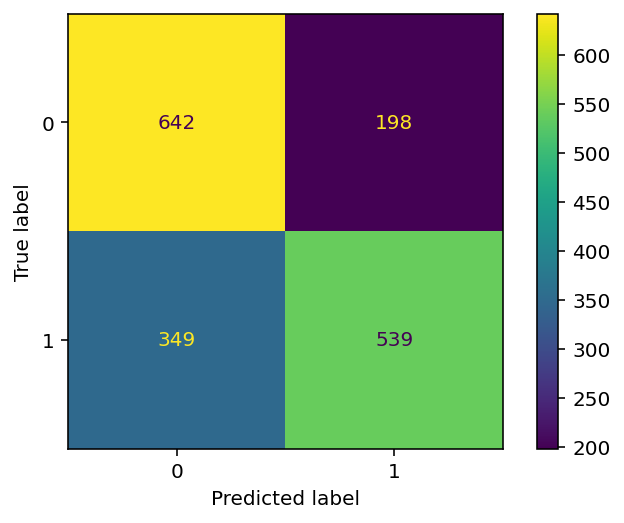

In [546]:
plot_confusion_matrix(mnb, test_X_vec, test_y);

In [66]:
X.iloc[[i for i in range(len(mnb.predict(test_X_vec))) if mnb.predict(test_X_vec[i]) == 1 and test_y[i] ==0]]

11      Trigger warning!!!! Is it true half of all wom...
14      [Recommendation] What are some thought provoki...
20           Ladies of Reddit: What hobbies do you enjoy?
25      Do you have sex with your husband even if you ...
47      What brief encounter in your life has really s...
                              ...                        
1792    Black women - what is your experience been lik...
1799      How should I approach prostate play with my BF?
1806    Ladies who are hypochondriacs, how do you cope...
1814    Women of reddit how many inches is considered ...
1815    What do you think about asking a man for consent?
Length: 206, dtype: object

In [67]:
X.iloc[[i for i in range(len(mnb.predict(test_X_vec))) if mnb.predict(test_X_vec[i]) == 0 and test_y[i] ==1]]

7       What birth control would be best considering t...
12      Hi is this a good potential tinder Profile/can...
17      Women who worked in the porn industry and DONT...
21      Why do you think the mid-s so the - age range ...
33      Would you marry someone who cheated on you onc...
                              ...                        
1789    Have you ever dated someone who seemed too goo...
1798    The life you live is wealthy and amazing but y...
1807    What changes can a company implement to make t...
1810    If your partner stayed the EXACT same forever,...
1818         Penis size i am small how real are big ones?
Length: 323, dtype: object

In [547]:
X_vec = cvec.transform(X)

params = {'alpha': np.linspace(0,1,10)}
mnb_gs = GridSearchCV(mnb, params, n_jobs = 5, verbose = 1, cv = 5)

mnb_gs.fit(X_vec, y)
print(f"Best CV score of {round(mnb_gs.best_score_,4)} achieved with alpha = {round(mnb_gs.best_params_['alpha'],4)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Best CV score of 0.6636 achieved with alpha = 0.7778


[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    2.0s finished


### Classifying using word vector and sentiment scores

In [335]:
X_cont = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

X_sent = pd.concat([AW_posts_df[['sia_neg', 'sia_pos', 'senti_score']], AW_comments_df[['sia_neg', 'sia_pos', 'senti_score']],
                  AM_posts_df[['sia_neg', 'sia_pos', 'senti_score']], AM_comments_df[['sia_neg', 'sia_pos', 'senti_score']]], axis = 0)

X = pd.concat([X_cont, X_sent], axis = 1)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext']),
                    np.zeros_like(AW_comments_df['body']),
                    np.ones_like(AM_posts_df['title_selftext']),
                    np.ones_like(AM_comments_df['body'])]).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 11)

tvec = TfidfVectorizer()
#tvec.fit(X_train.iloc[:,0])

X_train_vec = pd.merge(pd.DataFrame(tvec.fit_transform(X_train.iloc[:,0]).todense()), X_train.iloc[:,1:], how = 'inner', 
                        left_index= True, right_index= True)

X_test_vec = pd.merge(pd.DataFrame(tvec.transform(X_test.iloc[:,0]).todense()), X_test.iloc[:,1:], how = 'inner', 
                        left_index= True, right_index= True)

In [336]:
logreg = LogisticRegression(max_iter = 10_000)
logreg.fit(X_train_vec,y_train)
logreg.score(X_train_vec, y_train)

0.7176446534451032

In [337]:
logreg.score(X_test_vec, y_test)

0.4989622249896222

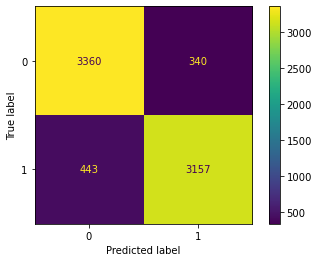

In [76]:
plot_confusion_matrix(logreg, X,y);

In [77]:
logreg.score(X,y)

0.8927397260273973

In [78]:
cross_val_score(logreg, X, y, cv = 5)

array([0.51027397, 0.50410959, 0.58424658, 0.49863014, 0.49726027])

### Classifying using word vector and sentiment scores, as well as emoji count

In [348]:
X_cont = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)


X_sent_emo = pd.concat([AW_posts_df[AW_posts_df['title_selftext'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']], 
                        AW_comments_df[AW_comments_df['body'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']],
                        AM_posts_df[AM_posts_df['title_selftext'].notna()][['sia_neg', 'sia_pos', 'senti_score','emojis']], 
                        AM_comments_df[AM_comments_df['body'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']]], axis = 0)

X = pd.concat([X_cont, X_sent_emo], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 11)

tvec = TfidfVectorizer()
X_train_vec = pd.merge(pd.DataFrame(tvec.fit_transform(X_train.iloc[:,0]).todense()), X_train.iloc[:,1:], how = 'inner', 
                        left_index= True, right_index= True)

X_test_vec = pd.merge(pd.DataFrame(tvec.transform(X_test.iloc[:,0]).todense()), X_test.iloc[:,1:], how = 'inner', 
                        left_index= True, right_index= True)

In [318]:
X_test_vec.shape

(2409, 9745)

In [70]:
y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext']),
                    np.zeros_like(AW_comments_df['body']),
                    np.ones_like(AM_posts_df['title_selftext']),
                    np.ones_like(AM_comments_df['body'])]).astype(int)

In [320]:
logreg = LogisticRegression(max_iter = 10_000)
logreg.fit(X_train_vec,y_train)
logreg.score(X_train_vec, y_train)

0.7176446534451032

In [321]:
logreg.score(X_test_vec, y_test)

0.5014528850145289

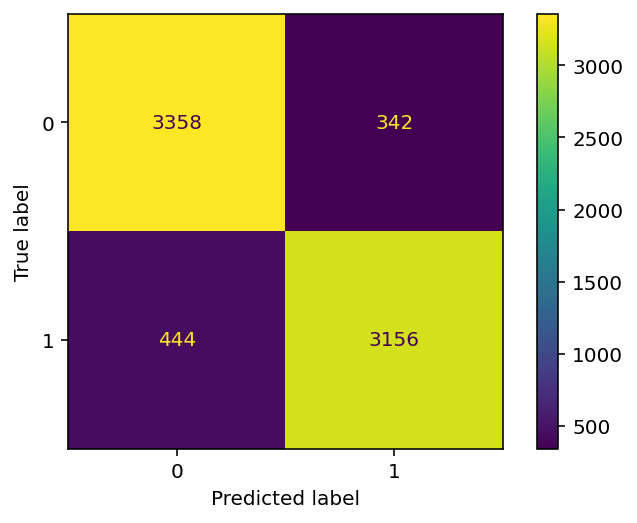

In [290]:
plot_confusion_matrix(logreg, X,y);

In [291]:
logreg.score(X,y)

0.8923287671232877

### BAGGING

In [79]:
bag = BaggingClassifier()
bag.fit(X_train, y_train)
bag.score(X_train, y_train)

0.9979554283377632

In [80]:
bag.score(X_test, y_test)

0.9319219593192196

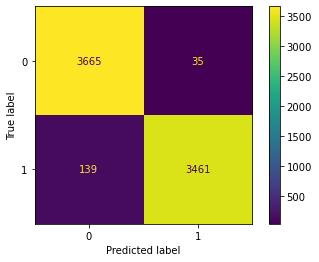

In [81]:
plot_confusion_matrix(bag, X,y);

In [ ]:
cross_val_score(bag,X,y)

In [ ]:
for i in range(5):
    X.sample(n = X.shape[0], replace = True)
    train_X, test_X, train_y, test_y = train_test_split(X,y)
    print(f"Score for first cross-val test sample # {i+1} = {bag.score(test_X, test_y)}")

In [ ]:
for i in range(5):
    X.sample(n = X.shape[0], replace = True)
    train_X, test_X, train_y, test_y = train_test_split(X,y)
    bag.fit(train_X, train_y)
    print(f"Score for cross-val test sample #{i+1} = {bag.score(test_X, test_y)}")

### OTHER MODELS

**K-Nearest Neighbors - missing scaling!**

In [446]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 0.33)

tvec = TfidfVectorizer()
#stan = StandardScaler()
train_X_vec = tvec.fit_transform(train_X)
#train_X_vec_sc = stan.fit_transform(train_X_vec)

test_X_vec = tvec.transform(test_X)
#test_X_vec_sc = stan.transform(test_X_vec)

In [442]:
knn = KNeighborsClassifier()
knn.fit(train_X_vec, train_y)
knn.score(test_X_vec, test_y)

0.5765803988120493

In [ ]:
plot_confusion_matrix(knn, X_vec, y);

In [90]:
X_vec = cvec.transform(X)

In [ ]:
for k in range(1,11):
    knn = KNeighborsClassifier(k)
    print(f"k = {k} --> score = {round(cross_val_score(knn, X_vec, y).mean(),4)}")

**Random Forest Classifier**

In [390]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 0.2)

tvec = TfidfVectorizer()
train_X_vec = tvec.fit_transform(train_X)
test_X_vec = tvec.transform(test_X)

In [345]:
rfc = RandomForestClassifier()
rfc.fit(train_X_vec, train_y)
rfc.score(train_X_vec, train_y)

0.9904109589041096

In [346]:
rfc.score(test_X_vec, test_y)

0.7191780821917808

In [347]:
params = {'bootstrap': [True],
 'ccp_alpha': np.linspace(0,1,5),
 'criterion': ['gini'],
 'max_depth': [2,5,10,15],
 'min_samples_leaf': [1,2,3,4,5],
 'n_estimators': [25,50,75,100,125]}

rfc_gs = GridSearchCV(rfc, params, cv = 5, n_jobs = 5, verbose = 1)

rfc_gs.fit(train_X_vec, train_y)
rfc_gs.best_score_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   20.0s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  5.9min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed:  8.4min
[Parallel(n_jobs=5)]: Done 2500 out of 2500 | elapsed:  8.7min finished


0.6945205479452057

### cvec / tfidf MNB GridSearch

In [348]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)


y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

In [349]:
cvec_mnb_pipe = Pipeline([('cvec', CountVectorizer()), 
                          ('mnb', MultinomialNB())])

cvec_mnb_params = {'cvec__stop_words': ['english', None],
                    'cvec__ngram_range': [(1,1), (1,2), (2,2), (1,3), (3,3)],
                  'cvec__max_features': [5_000, 10_000, None],
                    'cvec__max_df': [0.7, 0.8, 0.9],
                  'mnb__alpha': np.linspace(0,1,10)}

cvec_mnb_gs = GridSearchCV(cvec_mnb_pipe, cvec_mnb_params, cv = 5, verbose = 1, n_jobs = 5)
cvec_mnb_gs.fit(X,y)
cvec_mnb_gs.best_score_

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   30.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  2.9min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  4.7min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  7.0min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed:  9.5min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 12.5min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 15.4min
[Parallel(n_jobs=5)]: Done 4500 out of 4500 | elapsed: 17.6min finished


0.6628767123287671

In [ ]:
tfidf_mnb_pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                          ('mnb', MultinomialNB())])

tfidf_mnb_params = {'tfidf__stop_words': ['english', None],
                    'tfidf__ngram_range': [(1,1), (1,2), (2,2), (1,3), (3,3)],
                  'tfidf__max_features': [5_000, 10_000, None],
                    'tfidf__max_df': [0.7, 0.8, 0.9],
                  'mnb__alpha': np.linspace(0,1,10)}

tfidf_mnb_gs = GridSearchCV(cvec_mnb_pipe, cvec_mnb_params, cv = 5, verbose = 1, n_jobs = 5)
tfidf_mnb_gs.fit(X,y)
tfidf_mnb_gs.best_score_

**Logistic Regression**

In [394]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 0.33)


tvec = TfidfVectorizer(stop_words = 'english')
train_X_vec = tvec.fit_transform(train_X)
test_X_vec = tvec.transform(test_X)

In [395]:
logreg = LogisticRegression(C = 0.5)
logreg.fit(train_X_vec, train_y)
logreg.score(train_X_vec, train_y)

0.8469579761655864

In [419]:
logreg.score(test_X_vec, test_y)

0.7023661270236613

In [ ]:
cross_val_score(logreg, train_X_vec+test_X_vec, train_y+test_y)

In [415]:
logreg.predict(train_X_vec)

array([1, 1, 1, ..., 1, 0, 1])

In [416]:
train_X_vec.shape

(4783, 9234)

In [417]:
test_X_vec.shape

(2357, 9234)

**XGBC**

In [358]:
xgbc = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')
xgbc.fit(train_X_vec, train_y)
xgbc.score(train_X_vec, train_y)

0.9039051318748722

In [359]:
xgbc.score(test_X_vec, test_y)

0.7027812370278124

### Voting classifiers

#### Without GridSearch

In [369]:
vote = VotingClassifier([('xgbc', XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')),
    ('rfc', RandomForestClassifier()),
    ('logreg', LogisticRegression()),
  #  ('knn', KNeighborsClassifier())],
                       verbose = 1)

In [370]:
vote.fit(train_X_vec, train_y)
vote.score(train_X_vec, train_y)

[Voting] ..................... (1 of 4) Processing xgbc, total=   2.3s
[Voting] ...................... (2 of 4) Processing rfc, total=   3.4s
[Voting] ................... (3 of 4) Processing logreg, total=   0.2s
[Voting] ...................... (4 of 4) Processing knn, total=   0.0s


0.9685135964015539

In [371]:
vote.score(test_X_vec, test_y)

0.7376504773765048

#### Using GridSearch

In [4]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 0.2)

In [6]:
# knn_pipe = Pipeline ([
#     ('stan', StandardScaler()),
#     ('knn', KNeighborsClassifier())
# ])

logreg_pipe = Pipeline ([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())])

rfc_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfc', RandomForestClassifier())])

xgbc_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('xgbc', XGBClassifier(use_label_encoder=False, eval_metric = 'logloss'))
])

In [29]:
rfc_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tvec', 'rfc', 'tvec__analyzer', 'tvec__binary', 'tvec__decode_error', 'tvec__dtype', 'tvec__encoding', 'tvec__input', 'tvec__lowercase', 'tvec__max_df', 'tvec__max_features', 'tvec__min_df', 'tvec__ngram_range', 'tvec__norm', 'tvec__preprocessor', 'tvec__smooth_idf', 'tvec__stop_words', 'tvec__strip_accents', 'tvec__sublinear_tf', 'tvec__token_pattern', 'tvec__tokenizer', 'tvec__use_idf', 'tvec__vocabulary', 'rfc__bootstrap', 'rfc__ccp_alpha', 'rfc__class_weight', 'rfc__criterion', 'rfc__max_depth', 'rfc__max_features', 'rfc__max_leaf_nodes', 'rfc__max_samples', 'rfc__min_impurity_decrease', 'rfc__min_impurity_split', 'rfc__min_samples_leaf', 'rfc__min_samples_split', 'rfc__min_weight_fraction_leaf', 'rfc__n_estimators', 'rfc__n_jobs', 'rfc__oob_score', 'rfc__random_state', 'rfc__verbose', 'rfc__warm_start'])

In [5]:
# logreg_params = {
#     'logreg_pipe__tvec__max_df': [0.8, 0.9, 1],
#     'logreg_pipe__tvec__ngram_range': [(1,1), (1,2)],
#     'logreg_pipe__tvec__stop_words': [None, 'english'],
#     'logreg_pipe__tvec__use_idf': [True, False],
#     'logreg_pipe__logreg__C': np.linspace(0,1,5)
# }

logreg_params = {
    'tvec__max_df': [0.8, 0.9, 1],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [None, 'english'],
    'tvec__use_idf': [True, False],
    'logreg__C': np.linspace(0.00000001,1,5)
}

rfc_params = {
    'tvec__max_df': [0.8, 0.9, 1],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [None, 'english'],
    'tvec__use_idf': [True, False],
    #'rfc__max_depth': , 
    'rfc__max_features': [None, 10_000, 5_000], 
    #'rfc__max_leaf_nodes', 
    #'rfc__max_samples', 'rfc__min_impurity_decrease', 
    #'rfc__min_impurity_split': []
    'rfc__min_samples_leaf': [1,5,10], 
    #'rfc__min_samples_split', 'rfc__min_weight_fraction_leaf', 
    'rfc__n_estimators': [5, 10, 15]
}

In [17]:
logreg_pipe.fit(train_X, train_y)

Pipeline(steps=[('tvec', TfidfVectorizer()), ('logreg', LogisticRegression())])

In [20]:
logreg_pipe.score(test_X, test_y)

0.7275910364145658

In [26]:
logreg_pipe_gs = GridSearchCV(logreg_pipe, logreg_params, n_jobs = 3, cv = 5, verbose = 1, return_train_score=True)
logreg_pipe_gs.fit(train_X,train_y)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  2.3min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=1,
             param_grid={'logreg__C': array([1.00000000e-08, 2.50000008e-01, 5.00000005e-01, 7.50000002e-01,
       1.00000000e+00]),
                         'tvec__max_df': [0.8, 0.9, 1],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english'],
                         'tvec__use_idf': [True, False]},
             verbose=1)

In [27]:
logreg_pipe_gs.score(train_X,train_y)

0.9264705882352942

In [28]:
logreg_pipe_gs.score(test_X,test_y)

0.7303921568627451

In [7]:
rfc_pipe_gs = GridSearchCV(rfc_pipe, rfc_params, n_jobs = 3, cv = 5, verbose = 2, return_train_score=True)
rfc_pipe_gs.fit(train_X,train_y)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 12.7min


KeyboardInterrupt: 

In [369]:
vote = VotingClassifier([('xgbc', XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')),
    ('rfc', RandomForestClassifier()),
    ('logreg', LogisticRegression()),
  #  ('knn', KNeighborsClassifier())],
                       verbose = 1)

In [370]:
vote.fit(train_X_vec, train_y)
vote.score(train_X_vec, train_y)

[Voting] ..................... (1 of 4) Processing xgbc, total=   2.3s
[Voting] ...................... (2 of 4) Processing rfc, total=   3.4s
[Voting] ................... (3 of 4) Processing logreg, total=   0.2s
[Voting] ...................... (4 of 4) Processing knn, total=   0.0s


0.9685135964015539

In [371]:
vote.score(test_X_vec, test_y)

0.7376504773765048

### PCA, if I'm lucky

In [427]:
X_cont = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)


X_sent_emo = pd.concat([AW_posts_df[AW_posts_df['title_selftext'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']], 
                        AW_comments_df[AW_comments_df['body'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']],
                        AM_posts_df[AM_posts_df['title_selftext'].notna()][['sia_neg', 'sia_pos', 'senti_score','emojis']], 
                        AM_comments_df[AM_comments_df['body'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']]], axis = 0)

X = pd.concat([X_cont, X_sent_emo], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_cont,y, test_size = 0.33, random_state = 11)

tvec.fit(X_train)

TfidfVectorizer()

In [430]:
logreg = LogisticRegression()
logreg.fit(tvec.fit_transform(X_train), y_train)

LogisticRegression()

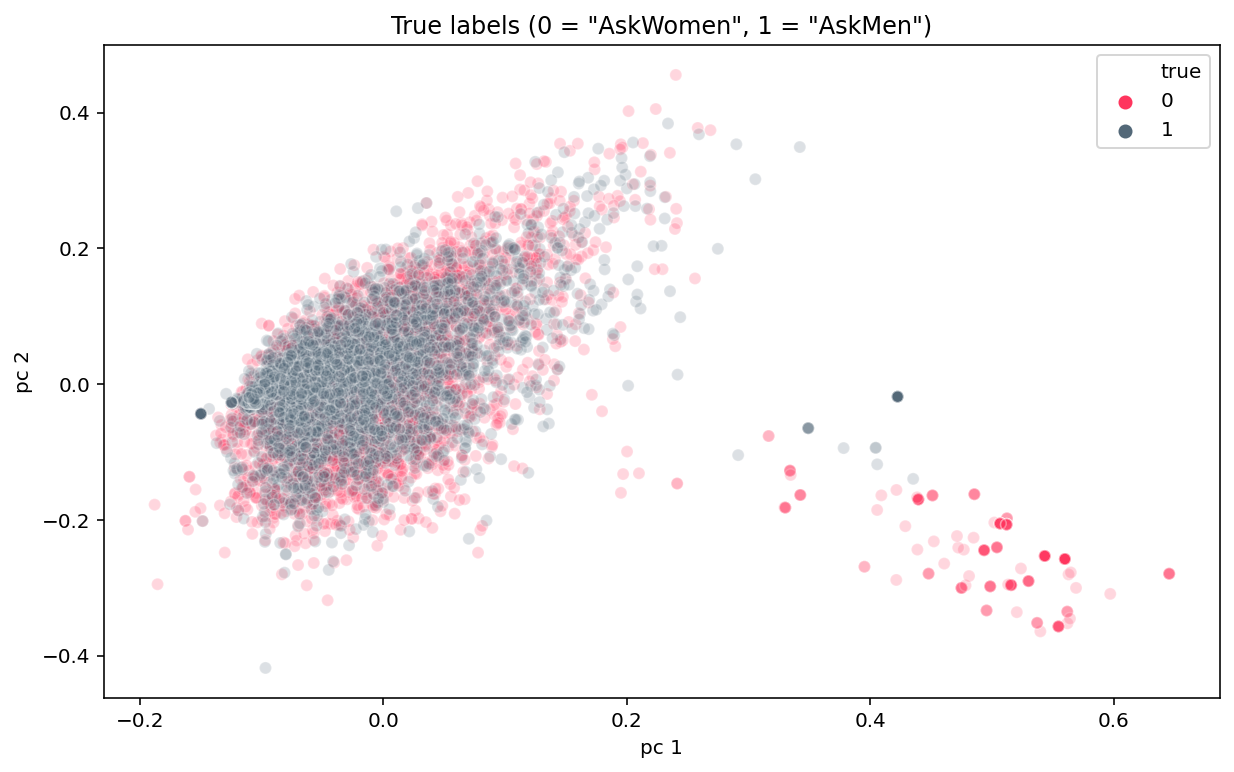

In [428]:
pca = PCA(n_components=2)
X_cont_vec = tvec.transform(X_cont)
pcomps = pca.fit_transform(pd.DataFrame(X_cont_vec.todense())) # only word vector
pcomps_df = pd.DataFrame(data = pcomps, columns = ['pc 1', 'pc 2'])

pcomps_df['true'] = y
#pcomps_df['logreg'] = logreg.predict(X_cont_vec)

plt.figure(figsize = (10,6))
plt.title('Principal Component Analysis for vectorized reddit entries')
plt.title('True labels (0 = "AskWomen", 1 = "AskMen")')
sns.scatterplot(data = pcomps_df, x = 'pc 1', y = 'pc 2', hue = 'true', alpha = 0.2, palette = ['#ff355e','#536878'])


plt.savefig('./visualizations/pca.png');

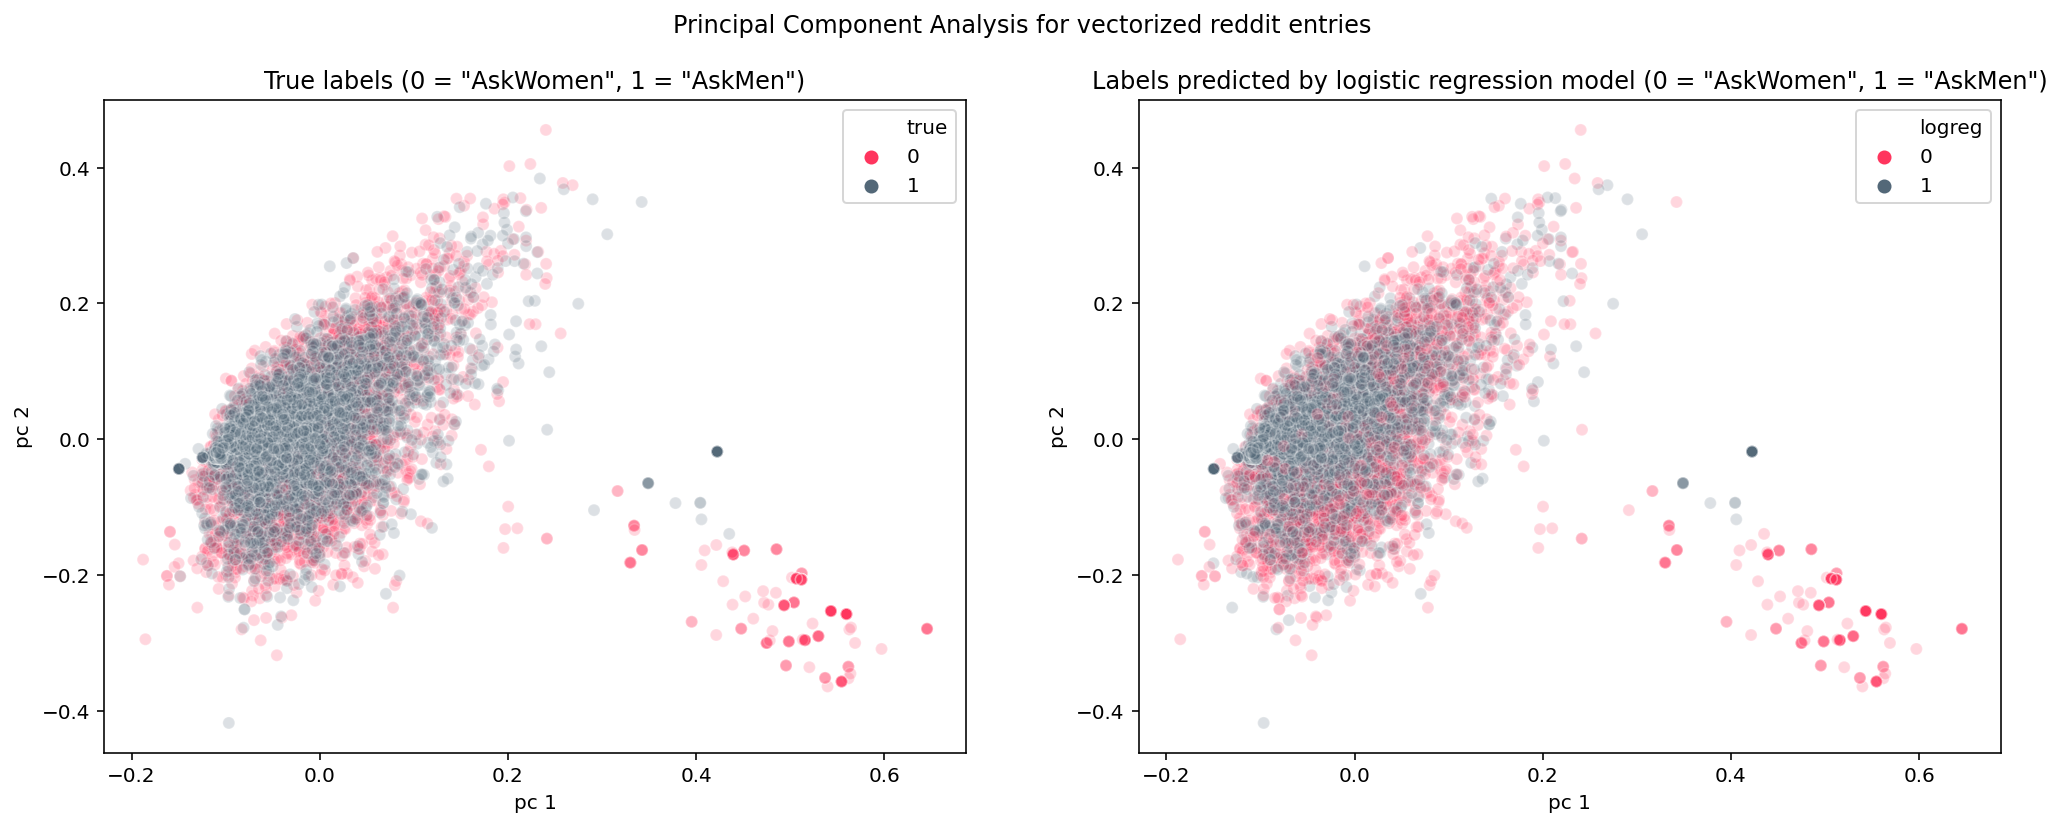

In [431]:
pca = PCA(n_components=2)
X_cont_vec = tvec.transform(X_cont)
pcomps = pca.fit_transform(pd.DataFrame(X_cont_vec.todense())) # only word vector
pcomps_df = pd.DataFrame(data = pcomps, columns = ['pc 1', 'pc 2'])

pcomps_df['true'] = y
pcomps_df['logreg'] = logreg.predict(X_cont_vec)

plt.figure(figsize = (17,6))
plt.suptitle('Principal Component Analysis for vectorized reddit entries')
plt.subplot(1,2,1)
plt.title('True labels (0 = "AskWomen", 1 = "AskMen")')
sns.scatterplot(data = pcomps_df, x = 'pc 1', y = 'pc 2', hue = 'true', alpha = 0.2, palette = ['#ff355e','#536878'])

plt.subplot(1,2,2)
plt.title('Labels predicted by logistic regression model (0 = "AskWomen", 1 = "AskMen")')
sns.scatterplot(data = pcomps_df, x = 'pc 1', y = 'pc 2', hue = 'logreg', alpha = 0.2, palette = ['#ff355e','#536878'])

plt.savefig('./visualizations/pca2.png');

In [413]:
X_train_vec.shape

(4783, 9748)

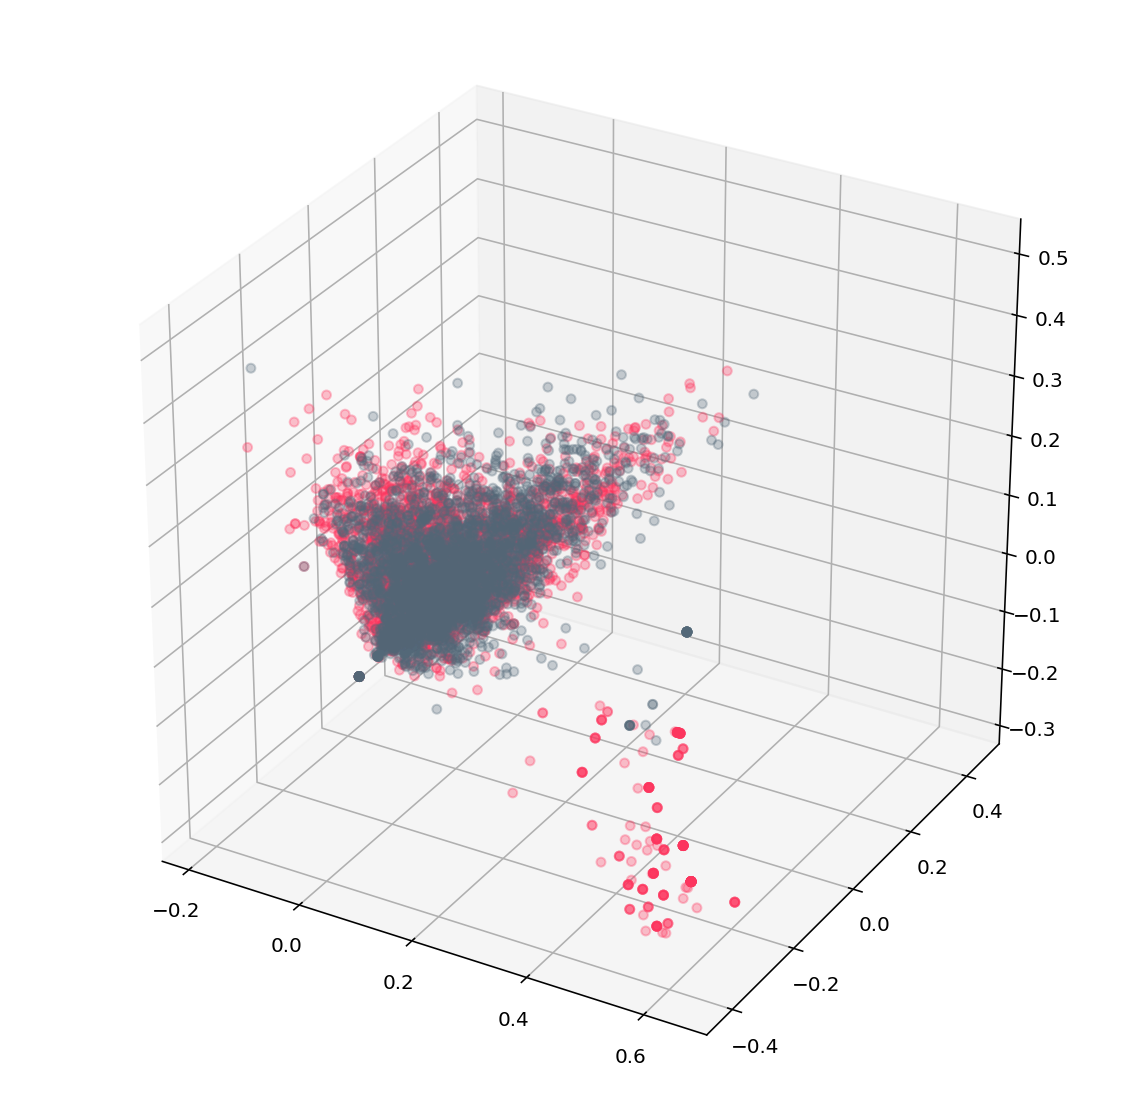

<Figure size 504x504 with 0 Axes>

In [438]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)
X_cont_vec = tvec.transform(X_cont)
pcomps = pca.fit_transform(pd.DataFrame(X_cont_vec.todense())) # only word vector
pcomps_df = pd.DataFrame(data = pcomps, columns = ['pc 1', 'pc 2', 'pc 3'])
pcomps_df['true'] = y
pcomps_df['col_true'] = pcomps_df['true'].map({0: '#ff355e', 1: '#536878'})
pcomps_df['logreg'] = logreg.predict(X_cont_vec)
pcomps_df['col_logreg'] = pcomps_df['logreg'].map({0: '#ff355e',  1: '#536878'})

plt.figure(figsize = (7,7))
ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_true']);
plt.savefig('./visualizations/pca3d-true.png')

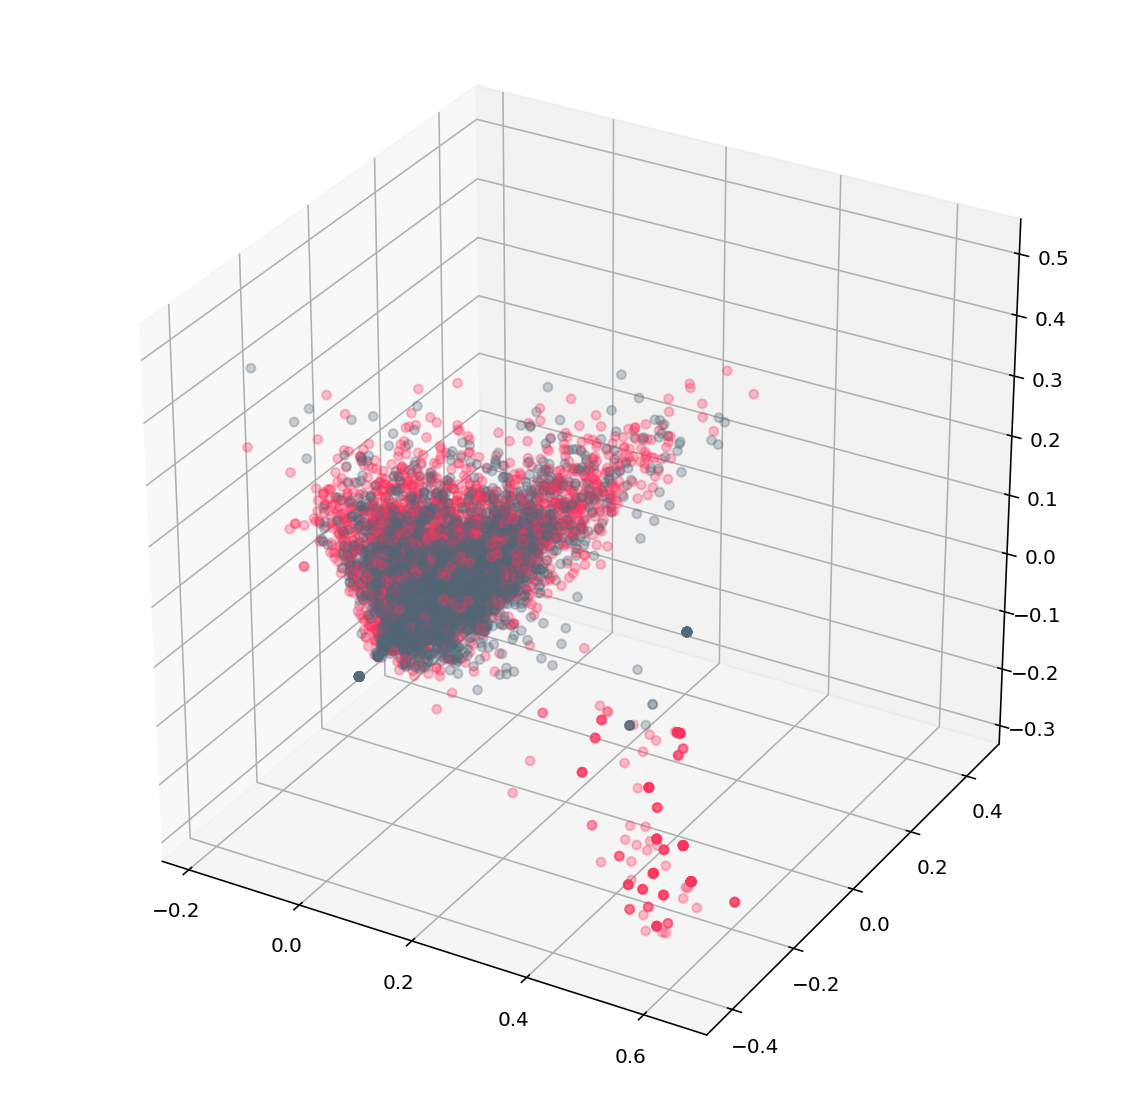

<Figure size 504x504 with 0 Axes>

In [440]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

plt.figure(figsize = (7,7))
ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_logreg']);

plt.savefig('./visualizations/pca3d-logreg.png')

In [447]:
knn = KNeighborsClassifier()
knn.fit(tvec.fit_transform(X_train), y_train)

KNeighborsClassifier()

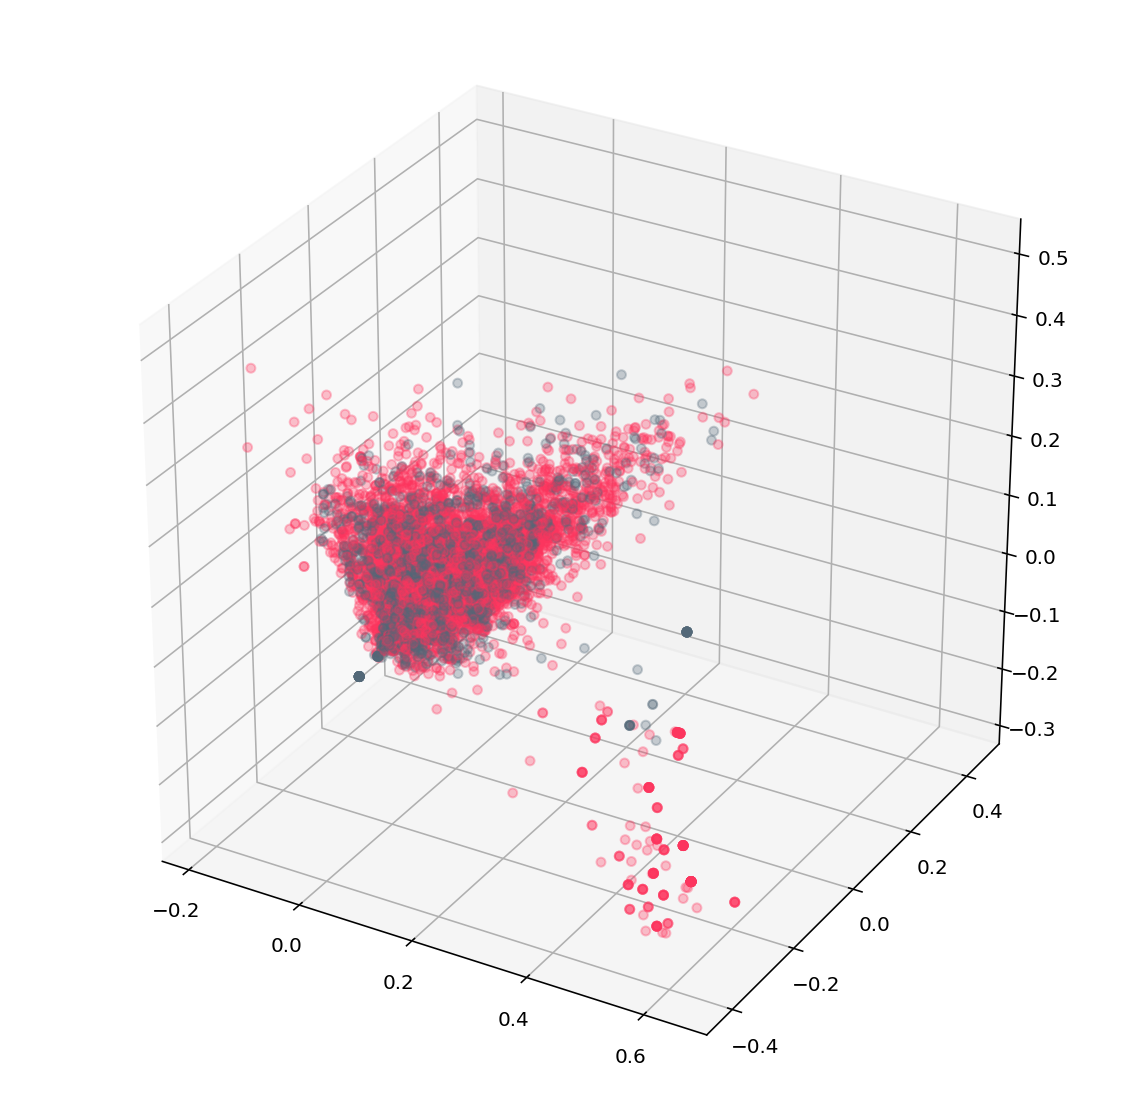

<Figure size 504x504 with 0 Axes>

In [448]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

pcomps_df['knn'] = knn.predict(X_cont_vec)
pcomps_df['col_knn'] = pcomps_df['knn'].map({0: '#ff355e',  1: '#536878'})

plt.figure(figsize = (7,7))
ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_knn']);

plt.savefig('./visualizations/pca3d-knn.png')